# 4 Task A: Individual Neural Networks for Each Forecast Horizon

## 4.1 Data Preparation

In [138]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.optim as optim
import joblib
import random
import matplotlib.pyplot as plt
import torch.nn as nn
from scipy.stats import pearsonr
import math
from sklearn.metrics import mean_squared_error
import seaborn as sns

### (a) Load the data from Nino3.4 data.csv

In [139]:
# Read the CSV file into a pandas DataFrame
data = pd.read_csv("Nino3.4_data.csv") 

### (b) Read test years from test years.csv. Extract all data rows from step (a) that match these test years to create your test set. This test data must remain untouched during training. You should use this test set to evaluate your model’s performance and report results

In [140]:
# select the "year" column and convert it into a Python list
test_years = pd.read_csv("test_years.csv")["year"].tolist()

### (c) Subset your test data based on the test years, then randomly partition the remainingdataset into training and validation sets. Choose an appropriate split ratio that ensures sufficient data for both training and validation.

In [141]:
# Select rows from 'data' where the "year" column is in the test_years list
test_data = data[data["year"].isin(test_years)].reset_index(drop=True)
# Select rows where the "year" column is NOT in the test_years list
train_val_data = data[~data["year"].isin(test_years)].reset_index(drop=True)

# Randomly split the remaining data into training and validation sets
train_data, val_data = train_test_split(train_val_data, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
# parameters:
# test_size=0.2 20% of the remaining data is used for validation
# random_state=42

### (d) Pre-processing: Apply scaling transformations to the input features (nino tminus2, nino tminus1, nino t). Scaling the target variables (nino tplus1 through nino tplus6) is optional - if you choose to scale them, save the target scalers for inverse transformation during evaluation. Apply the same transformations to the validation set.

Optional: You might also consider creating additional features from the month column. For example, some students find it helpful to encode the cyclical nature of months using sine and cosine transformations: sin(2π × month/12) and cos(2π × month/12). This can help the model understand that December is adjacent to January.

Note: Save your scaler objects for later use (e.g., using pickle or joblib).

In [142]:
# ---------- Define input and target features ----------
# past Nino3.4 indices
input_features = ["nino_tminus2", "nino_tminus1", "nino_t"]
# 1-6 month ahead predictions
target_features = ["nino_tplus1", "nino_tplus2", "nino_tplus3", "nino_tplus4", "nino_tplus5", "nino_tplus6"]

# ---------- Optional: add cyclic month features ----------
for df in [train_data, val_data, test_data]:
    df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
    df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)

    # Reset index to avoid misalignment
    df.reset_index(drop=True, inplace=True)

input_features_extended = input_features + ["month_sin", "month_cos"]

# ---------- Scale input features ----------
scaler_X = StandardScaler()
train_X_scaled = scaler_X.fit_transform(train_data[input_features_extended])
val_X_scaled = scaler_X.transform(val_data[input_features_extended])
test_X_scaled = scaler_X.transform(test_data[input_features_extended])

# ---------- scale target features ----------
scaler_y = StandardScaler()
train_y_scaled = scaler_y.fit_transform(train_data[target_features])
val_y_scaled = scaler_y.transform(val_data[target_features])
test_y_scaled = scaler_y.transform(test_data[target_features])

# Save scalers for later use
joblib.dump(scaler_X, "scaler_X.pkl")
joblib.dump(scaler_y, "scaler_y.pkl")

# ---------- Convert to PyTorch tensors ----------
train_X = torch.tensor(train_X_scaled, dtype=torch.float32)
val_X = torch.tensor(val_X_scaled, dtype=torch.float32)
test_X = torch.tensor(test_X_scaled, dtype=torch.float32)

train_y = torch.tensor(train_y_scaled, dtype=torch.float32)
val_y = torch.tensor(val_y_scaled, dtype=torch.float32)
test_y = torch.tensor(test_y_scaled, dtype=torch.float32)

# ---------- Create TensorDataset ----------
train_dataset = TensorDataset(train_X, train_y)
val_dataset = TensorDataset(val_X, val_y)
test_dataset = TensorDataset(test_X, test_y)

# ---------- Create DataLoader ----------
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Train size:", len(train_dataset))
print("Val size:", len(val_dataset))
print("Test size:", len(test_dataset))

Train size: 584
Val size: 146
Test size: 72


### (e) Train a neural network that predicts the Ni˜no3.4 index of the next month, i.e.nino tplus1 using reasonable hyperparameters. Ensure reproducibility by setting a seed throughout your code. Plot the training and validation loss curves across epochs.
    Note: Save your trained models in a format appropriate for your chosen framework. Common formats include .keras, .h5, .pth, .pt, or .onnx. Ensure your models can be loaded during evaluation

In [143]:
# ---------- Set random seeds for reproducibility ----------
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# ---------- Check for GPU availability ----------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------- Define the neural network model ----------
class NinoNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, dropout=0.1):
        super(NinoNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)

input_dim = train_X.shape[1]
model = NinoNet(input_dim).to(device)


In [ ]:
"""
parameters:
    hidden_dim=64
    dropout=0.1

Architecture:
    Input -> Hidden layer 1 (ReLU + Dropout)
          -> Hidden layer 2 (ReLU)
          -> Output layer (1 neuron for regression)
"""

### (f) Repeat (e) for the subsequent months, i.e., nino_tplus2, nino_tplus3,.. nino_tplus6. Together with part (e), this will give you six trained networks and six plots for training and validation loss, shown in one Figure


===== Training Model for Horizon 1 Month =====
Epoch [5/1000] Train Loss: 0.6232, Val Loss: 0.5425
Epoch [10/1000] Train Loss: 0.3740, Val Loss: 0.3469
Epoch [15/1000] Train Loss: 0.2339, Val Loss: 0.2451
Epoch [20/1000] Train Loss: 0.1831, Val Loss: 0.2030
Epoch [25/1000] Train Loss: 0.1636, Val Loss: 0.1784
Epoch [30/1000] Train Loss: 0.1380, Val Loss: 0.1600
Epoch [35/1000] Train Loss: 0.1332, Val Loss: 0.1482
Epoch [40/1000] Train Loss: 0.1164, Val Loss: 0.1383
Epoch [45/1000] Train Loss: 0.1093, Val Loss: 0.1323
Epoch [50/1000] Train Loss: 0.1154, Val Loss: 0.1277
Epoch [55/1000] Train Loss: 0.1079, Val Loss: 0.1216
Epoch [60/1000] Train Loss: 0.0954, Val Loss: 0.1188
Epoch [65/1000] Train Loss: 0.0997, Val Loss: 0.1149
Epoch [70/1000] Train Loss: 0.0931, Val Loss: 0.1112
Epoch [75/1000] Train Loss: 0.0951, Val Loss: 0.1091
Epoch [80/1000] Train Loss: 0.0944, Val Loss: 0.1083
Epoch [85/1000] Train Loss: 0.0929, Val Loss: 0.1068
Epoch [90/1000] Train Loss: 0.0956, Val Loss: 0.1044

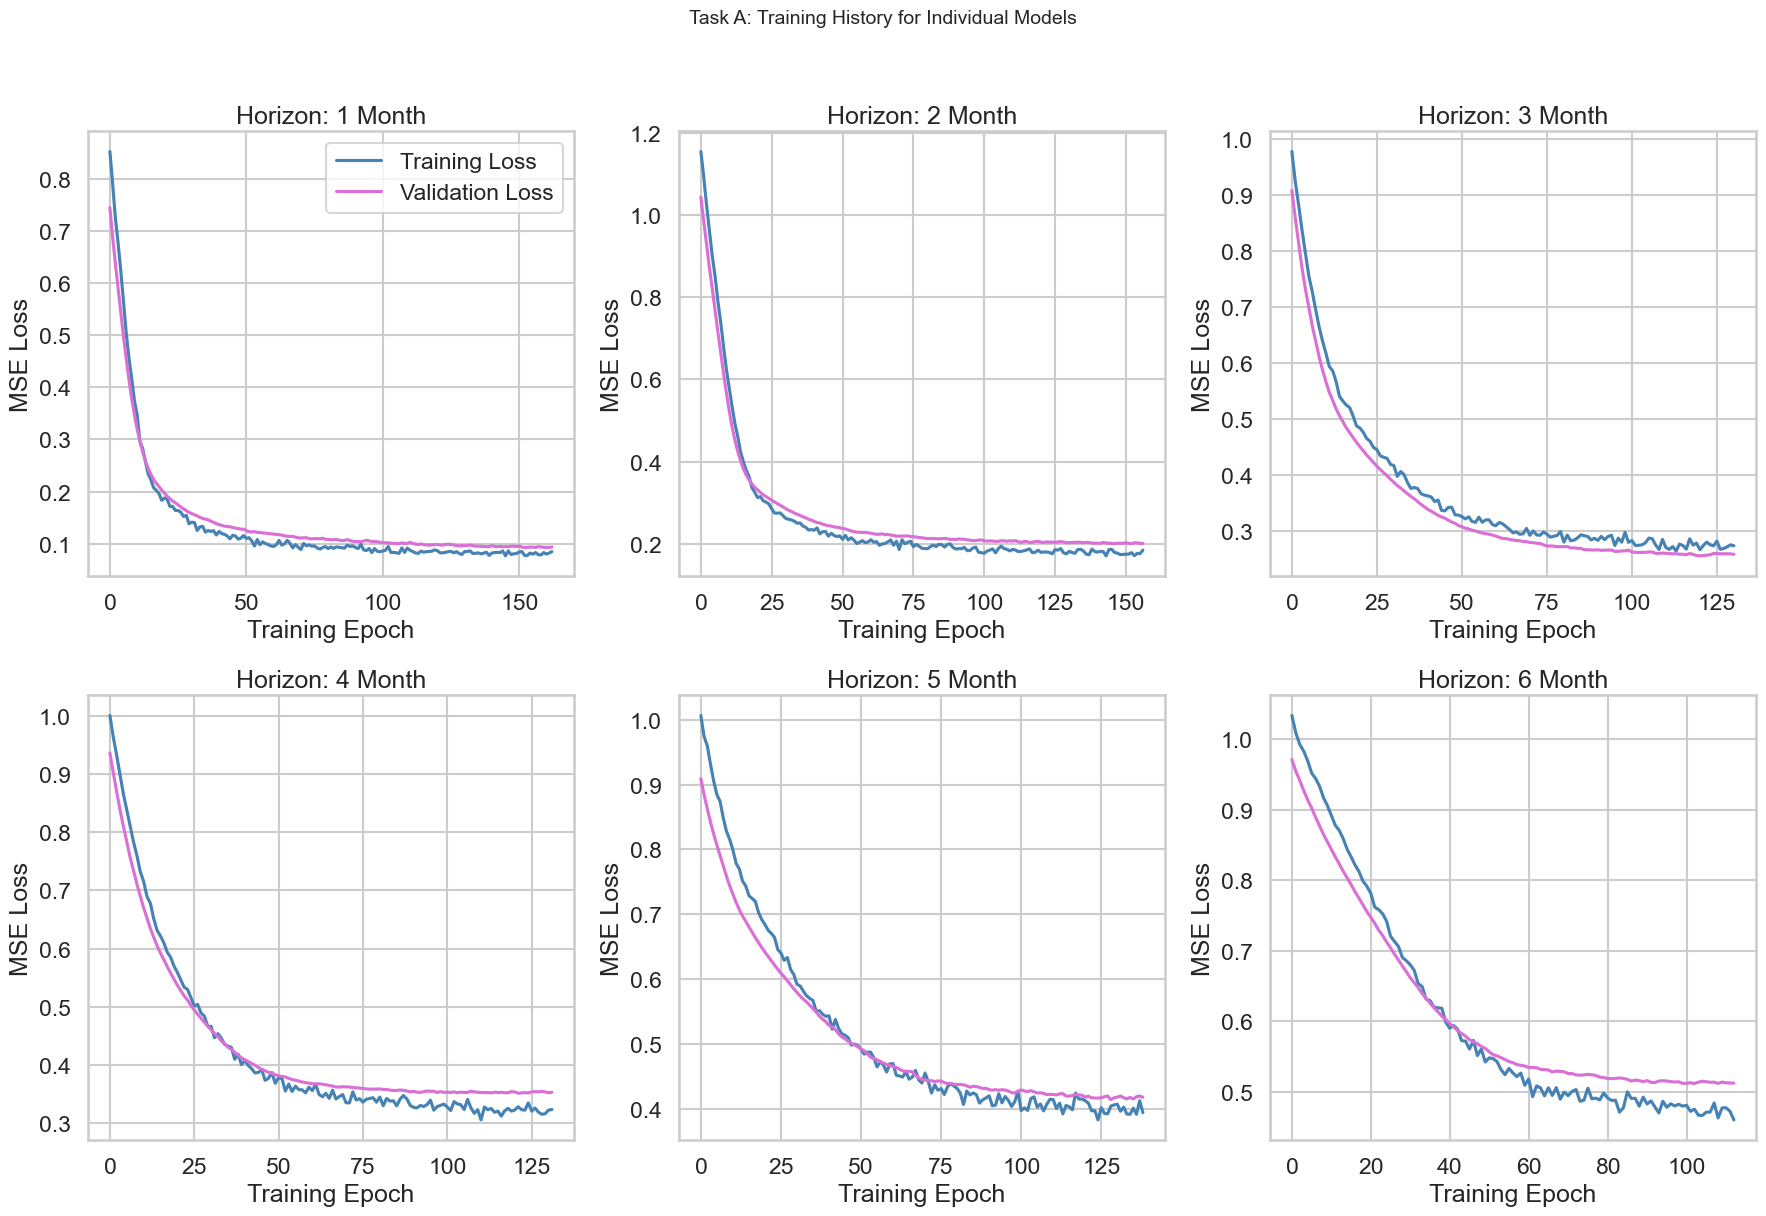

In [144]:
# ---------- Training function for a single horizon ----------
def train_single_horizon(horizon_index, epochs=1000, lr=1e-4, batch_size=32, patience=10):
    # Select target column for this horizon
    y_train_h = train_y[:, horizon_index].unsqueeze(1)
    y_val_h = val_y[:, horizon_index].unsqueeze(1)

    # Create DataLoaders
    train_dataset = TensorDataset(train_X, y_train_h)
    val_dataset = TensorDataset(val_X, y_val_h)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Initialize model, optimizer, loss function
    model = NinoNet(train_X.shape[1]).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    criterion = nn.MSELoss()

    # Record losses
    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    patience_counter = 0
    best_state = None

    for epoch in range(epochs):
        # --------- Training ---------
        model.train()
        total_train_loss = 0
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(Xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() * Xb.size(0)

        avg_train_loss = total_train_loss / len(train_loader.dataset)

        # --------- Validation ---------
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for Xb, yb in val_loader:
                Xb, yb = Xb.to(device), yb.to(device)
                out = model(Xb)
                loss = criterion(out, yb)
                total_val_loss += loss.item() * Xb.size(0)
        avg_val_loss = total_val_loss / len(val_loader.dataset)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        # --------- Early Stopping ---------
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}  # 保存最优权重
        else:
            patience_counter += 1

        if (epoch + 1) % 5 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    # Save model
    torch.save(model.state_dict(), f"nino_model_tplus{horizon_index+1}.pth")
    print(f" Model nino_model_tplus{horizon_index+1}.pth saved")
    
    # Load best weights
    model.load_state_dict(best_state)
    return model, train_losses, val_losses


# ---------- Training Loop ----------
all_train_losses, all_val_losses = [], []
num_models = 6
for i in range(num_models):
    print(f"\n===== Training Model for Horizon {i+1} Month =====")
    model, t_loss, v_loss = train_single_horizon(i)
    all_train_losses.append(t_loss)
    all_val_losses.append(v_loss)


# ---------- Plotting ----------
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i in range(num_models):
    ax = axes[i]
    ax.plot(all_train_losses[i], label="Training Loss", color="steelblue")
    ax.plot(all_val_losses[i], label="Validation Loss", color="orchid")
    ax.set_title(f"Horizon: {i+1} Month")
    ax.set_xlabel("Training Epoch")
    ax.set_ylabel("MSE Loss")
    ax.grid(True)
    if i == 0:
        ax.legend()

plt.suptitle("Task A: Training History for Individual Models", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
"""
    Parameters:
        horizon_index: 
            Index of the target column in train_y/val_y
        epochs: 1000
            Maximum number of epochs for training
        lr: 1e-4
            Learning rate for the optimizer
        batch_size: 32
            Batch size for DataLoader
        patience: 10
            Early stopping patience
"""

### (j) Apply the same transformations to the test set as you did to the training and validation sets

In [145]:
# ---------- Load saved scalers ----------
scaler_X = joblib.load('scaler_X.pkl')
scaler_y = joblib.load('scaler_y.pkl')

# ---------- Define input and target columns ----------
X_features = ['nino_tminus2', 'nino_tminus1', 'nino_t', 'month_sin', 'month_cos']
y_targets = ['nino_tplus1', 'nino_tplus2', 'nino_tplus3', 
             'nino_tplus4', 'nino_tplus5', 'nino_tplus6']

# ---------- Scale input features using the previously fitted scaler ----------
X_test_scaled = scaler_X.transform(test_data[X_features])
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)

# ---------- Keep original target values for evaluation ----------
y_test_orig = test_data[y_targets].values  # shape (N,6)

# ---------- Verification ----------
print("Verification complete:")
print(f"X_test_tensor: {X_test_tensor.shape}, y_test_orig: {y_test_orig.shape}")

Verification complete:
X_test_tensor: torch.Size([72, 5]), y_test_orig: (72, 6)


### (k) Use your models to forecast the Ni˜no3.4 index on the test set for the months ahead they are designed for

In [146]:
# ---------- Define the model structure ----------
# Must match the structure used during training
class NinoNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, dropout=0.1):
        super(NinoNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)


# ---------- Prepare for multi-horizon prediction ----------
horizons = [1, 2, 3, 4, 5, 6]
results = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Extract mean and scale for each target feature for inverse transformation
means = scaler_y.mean_        # 6
scales = scaler_y.scale_      # 6


### (l) Evaluate each model by calculating the RMSE and Pearson Correlation Coefficient between the predicted and true values (as defined in Section 3.4).

In [147]:
for h in horizons:
    # ---------- Load trained model ----------
    model = NinoNet(input_dim=X_test_tensor.shape[1]).to(device)
    model.load_state_dict(torch.load(f"nino_model_tplus{h}.pth", map_location=device))
    model.eval()  # turn off dropout and batchnorm

    # ---------- Make predictions ----------
    with torch.no_grad():
        preds_scaled = model(X_test_tensor).cpu().numpy().reshape(-1,1)  # (N,1)

    # ---------- Inverse transform to original scale ----------
    col_idx = h - 1  # tplus1 -> index 0, tplus6 -> index 5
    preds_orig = preds_scaled * scales[col_idx] + means[col_idx]  # (N,1)
    true_orig = y_test_orig[:, col_idx].reshape(-1,1)            # (N,1)

    # ---------- Evaluate predictions ----------
    rmse = math.sqrt(mean_squared_error(true_orig, preds_orig))
    corr, _ = pearsonr(true_orig.flatten(), preds_orig.flatten())

    results.append({"Horizon (month ahead)": h, "RMSE": rmse, "Pearson r": corr})

### (m) Display results in a table showing RMSE and correlation coefficients for each forecast horizon (1-6 months ahead

In [150]:
# ---------- Summarize results ----------
results_df_A = pd.DataFrame(results)
print("Results for separate-Output Model:")
print(results_df_A.to_string(index=False))

Results for separate-Output Model:
 Horizon (month ahead)   RMSE  Pearson r
                     1 0.2047     0.9771
                     2 0.3645     0.9241
                     3 0.4822     0.8604
                     4 0.5702     0.7968
                     5 0.6599     0.7177
                     6 0.7078     0.6673


## 4.4 Model Improvements
### (n) Apply a strategy that involves transfer learning to the model that predicts nino tplus6 and calculate the RMSE and correlation coefficient on the testing data.
    Hint: First train a model on an easier task such as nino tplus1, then continue training the same model to predict nino tplus6

In [168]:
# ---------- (n) Transfer Learning for Nino_tplus6 ----------

# ---------- Prepare tensors ----------
X_train_tensor = torch.tensor(train_X_scaled, dtype=torch.float32).to(device)
X_test_tensor  = torch.tensor(test_X_scaled, dtype=torch.float32).to(device)

# Manually scale single target column using scaler_y.mean_ / scale_
col_idx = list(scaler_y.feature_names_in_).index('nino_tplus6')  # find index
y_train_tplus6 = train_data[['nino_tplus6']].values.astype(float).reshape(-1,1)
y_test_tplus6  = test_data[['nino_tplus6']].values.astype(float).reshape(-1,1)

y_train_tplus6_scaled = (y_train_tplus6 - scaler_y.mean_[col_idx]) / scaler_y.scale_[col_idx]
y_test_tplus6_scaled  = (y_test_tplus6  - scaler_y.mean_[col_idx]) / scaler_y.scale_[col_idx]

y_train_tplus6_tensor = torch.tensor(y_train_tplus6_scaled, dtype=torch.float32).to(device)
y_test_tplus6_tensor  = torch.tensor(y_test_tplus6_scaled, dtype=torch.float32).to(device)

# ---------- Load pre-trained source model (t+1) ----------
source_model_path = "nino_model_tplus1.pth"
target_model_path = "nino_model_transfer_tplus6.pth"

input_dim = X_train_tensor.shape[1]
model = NinoNet(input_dim).to(device)
model.load_state_dict(torch.load(source_model_path, map_location=device))

# ---------- Replace output layer for t+6 ----------
model.model[-1] = nn.Linear(32, 1).to(device)

# ---------- Freeze bottom layers for transfer learning ----------
# Freeze first two layers, fine-tune last hidden + output
for p in model.model[:2].parameters():
    p.requires_grad = False
for p in model.model[2:].parameters():
    p.requires_grad = True

# ---------- Define optimizer for trainable parameters ----------
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, weight_decay=1e-5)
patience = 10
criterion = nn.MSELoss()

# ---------- Create validation subset ----------
from sklearn.model_selection import train_test_split
X_tr_sub, X_val_sub, y_tr_sub, y_val_sub = train_test_split(
    X_train_tensor.cpu(), y_train_tplus6_tensor.cpu(), test_size=0.2, random_state=42
)
X_tr_sub, X_val_sub = X_tr_sub.to(device), X_val_sub.to(device)
y_tr_sub, y_val_sub = y_tr_sub.to(device), y_val_sub.to(device)

best_val_loss = float('inf')
patience_counter = 0
epochs = 3000

for epoch in range(epochs):
    # Train step
    model.train()
    optimizer.zero_grad()
    out = model(X_tr_sub)
    loss = criterion(out, y_tr_sub)
    loss.backward()
    optimizer.step()
    
    # Validation step
    model.eval()
    with torch.no_grad():
        val_pred = model(X_val_sub)
        val_loss = criterion(val_pred, y_val_sub)

    
    # Early stopping check
    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        patience_counter = 0
        best_state = {k: v.cpu() for k, v in model.state_dict().items()}
    else:
        patience_counter += 1


    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

# ---------- Save best model ----------
if 'best_state' in locals():
    torch.save(best_state, target_model_path)
else:
    torch.save(model.state_dict(), target_model_path)
print("Model saved as：", target_model_path)

# ---------- Evaluate on test set ----------
model.eval()
with torch.no_grad():
    y_pred_scaled = model(X_test_tensor).cpu().numpy()  # shape (N,1)

# Inverse transform to original scale
y_pred_orig = y_pred_scaled * scaler_y.scale_[col_idx] + scaler_y.mean_[col_idx]
y_true_orig = y_test_tplus6  # original true values

rmse_transfer = np.sqrt(mean_squared_error(y_true_orig, y_pred_orig))
corr_transfer, _ = pearsonr(y_true_orig.flatten(), y_pred_orig.flatten())

print(" Transfer Learning Results for Nino_tplus6:")
print(f"RMSE: {rmse_transfer:.4f}")
print(f"Pearson r: {corr_transfer:.4f}")

Early stopping at epoch 1219
Model saved as： nino_model_transfer_tplus6.pth
 Transfer Learning Results for Nino_tplus6:
RMSE: 0.7181
Pearson r: 0.6677


In [ ]:
"""
Freeze first two layers, fine-tune last hidden + output
lr=1e-4, weight_decay=1e-5, patience=10, epochs=3000, batch_size=32, 
"""

# Task B: Multi-Output Neural Network

## 5.1 Neural Network Development

### (o) Subset your test data based on the test years, then randomly partition the remaining dataset into training and validation sets. Choose an appropriate split ratio that ensures sufficient data for both training and validation

### (p) Pre-processing: Apply scaling transformations to the input features (nino tminus2, nino tminus1, nino t). Scaling the target variables (nino tplus1 through nino tplus6) is optional - if you choose to scale them, save the target scalers for inverse trans- formation during evaluation. Apply the same transformations to the validation set.
    Note: Save your scaler objects for later use (e.g., using pickle or joblib).

### (q) Hyperparameter Tuning: Build and optimise a multi-output neural network that simultaneously predicts all six future months (nino tplus1 through nino tplus6) in a single forward pass. Note that your output layer must have 6 neurons corresponding to these six predictions. 
    Start with a reasonable baseline architecture and systematically explore how changes in network depth, width, and learning rate affect performance to prevent overfitting.

In [169]:
# task b-standard multi-output model

# ---------- Set random seeds for reproducibility ----------
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# ---------- Define Multi-Output Neural Network ----------
class MultiOutputNinoNet(nn.Module):
    def __init__(self, input_dim, output_dim=6):
        super(MultiOutputNinoNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, output_dim)
        )

    def forward(self, x):
        return self.model(x)


# ---------- Training function for multi-output model ----------
def train_multi_output(epochs=1000, lr=1e-4, batch_size=32, patience=10):
    # Data loading
    train_dataset = TensorDataset(train_X, train_y)
    val_dataset = TensorDataset(val_X, val_y)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Initialize model, optimizer, loss function
    model = MultiOutputNinoNet(train_X.shape[1], output_dim=train_y.shape[1]).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    criterion = nn.MSELoss()

    # Record losses
    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    patience_counter = 0
    best_state = None

    for epoch in range(epochs):
        # --------- Training ---------
        model.train()
        total_train_loss = 0
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(Xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() * Xb.size(0)

        avg_train_loss = total_train_loss / len(train_loader.dataset)

        # --------- Validation ---------
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for Xb, yb in val_loader:
                Xb, yb = Xb.to(device), yb.to(device)
                out = model(Xb)
                loss = criterion(out, yb)
                total_val_loss += loss.item() * Xb.size(0)
        avg_val_loss = total_val_loss / len(val_loader.dataset)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        # --------- Early Stopping ---------
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}
        else:
            patience_counter += 1

        if (epoch + 1) % 5 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    # Save best model
    torch.save(model.state_dict(), "nino_model_multi_output.pth")
    print("Model saved as：nino_model_multi_output.pth")

    # Load best weights
    model.load_state_dict(best_state)
    return model, train_losses, val_losses

# ---------- Main training loop ----------
print("\n===== Training Multi-Output Model =====")
model_multi, train_losses, val_losses = train_multi_output(
    epochs=1000, lr=1e-4, batch_size=32, patience=10
)


===== Training Multi-Output Model =====
Epoch [5/1000] Train Loss: 0.9520, Val Loss: 0.8871
Epoch [10/1000] Train Loss: 0.8473, Val Loss: 0.7814
Epoch [15/1000] Train Loss: 0.7152, Val Loss: 0.6647
Epoch [20/1000] Train Loss: 0.6057, Val Loss: 0.5701
Epoch [25/1000] Train Loss: 0.5350, Val Loss: 0.5131
Epoch [30/1000] Train Loss: 0.4937, Val Loss: 0.4768
Epoch [35/1000] Train Loss: 0.4566, Val Loss: 0.4497
Epoch [40/1000] Train Loss: 0.4360, Val Loss: 0.4260
Epoch [45/1000] Train Loss: 0.4047, Val Loss: 0.4048
Epoch [50/1000] Train Loss: 0.3869, Val Loss: 0.3874
Epoch [55/1000] Train Loss: 0.3687, Val Loss: 0.3727
Epoch [60/1000] Train Loss: 0.3609, Val Loss: 0.3566
Epoch [65/1000] Train Loss: 0.3521, Val Loss: 0.3469
Epoch [70/1000] Train Loss: 0.3294, Val Loss: 0.3372
Epoch [75/1000] Train Loss: 0.3318, Val Loss: 0.3293
Epoch [80/1000] Train Loss: 0.3243, Val Loss: 0.3255
Epoch [85/1000] Train Loss: 0.3167, Val Loss: 0.3206
Epoch [90/1000] Train Loss: 0.3102, Val Loss: 0.3189
Epoch 

In [ ]:
"""
epochs=1000, lr=1e-4, batch_size=32, patience=10

input_dim, output_dim=6
    nn.Linear(input_dim, 64),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, output_dim)
"""

### (r) Training Visualisation: Create a plot showing the training and validation loss curves for your best model.
    Note: Save your trained model in a format appropriate for your chosen fram

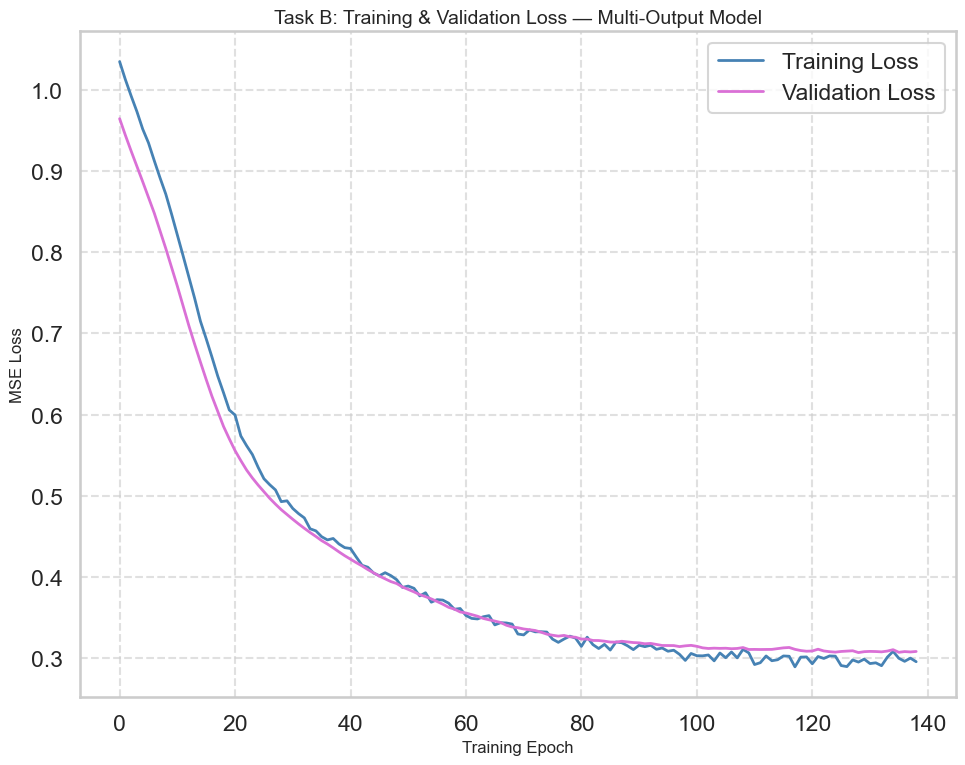

In [170]:
# ---------- Plot Training & Validation Curves ----------

plt.figure(figsize=(10, 8))
plt.plot(train_losses, label="Training Loss", color="steelblue", linewidth=2)
plt.plot(val_losses, label="Validation Loss", color="orchid", linewidth=2)

plt.title("Task B: Training & Validation Loss — Multi-Output Model", fontsize=14)
plt.xlabel("Training Epoch", fontsize=12)
plt.ylabel("MSE Loss", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

## 5.2  Model Evaluation
### (s) Calculate performance metrics on the testing data for each output (all 6 forecast horizons) using the metrics defined in Section 3.4

In [171]:
# ---------- Prepare test data ----------
X_test_np = X_test_tensor.cpu().numpy()
y_test_np = y_test_orig  # (N, 6)

# ---------- Load model and predict ----------
model = MultiOutputNinoNet(input_dim=X_test_tensor.shape[1])
model.load_state_dict(torch.load("nino_model_multi_output.pth", map_location="cpu"))
model.eval()

with torch.no_grad():
    y_pred = model(X_test_tensor).cpu().numpy()  # shape (N, 6)

# ---------- Inverse transform predictions and true values ----------
# Note: scaler_y is fitted on the training set target_features
y_pred = scaler_y.inverse_transform(y_pred)
y_true = scaler_y.inverse_transform(test_y_scaled)  # ← Make sure this is test_y_scaled


# ---------- Compute RMSE and Pearson r for each prediction step ----------

rmse_list_B, r_list_B = [], []
for i in range(6):
    rmse = np.sqrt(mean_squared_error(y_true[:, i], y_pred[:, i]))
    r, _ = pearsonr(y_true[:, i], y_pred[:, i])
    rmse_list_B.append(rmse)
    r_list_B.append(r)
    print(f"Horizon {i+1}: RMSE = {rmse:.4f}, Pearson r = {r:.4f}")

results_df_B = pd.DataFrame({
    "Horizon (month ahead)": np.arange(1, 7),
    "RMSE": rmse_list_B,
    "Pearson r": r_list_B
})

print(" Multi-Output Model Test Performance:")
print(results_df_B.to_string(index=False))

Horizon 1: RMSE = 0.1951, Pearson r = 0.9790
Horizon 2: RMSE = 0.3395, Pearson r = 0.9335
Horizon 3: RMSE = 0.4619, Pearson r = 0.8739
Horizon 4: RMSE = 0.5731, Pearson r = 0.7968
Horizon 5: RMSE = 0.6539, Pearson r = 0.7263
Horizon 6: RMSE = 0.7248, Pearson r = 0.6574
 Multi-Output Model Test Performance:
 Horizon (month ahead)   RMSE  Pearson r
                     1 0.1951     0.9790
                     2 0.3395     0.9335
                     3 0.4619     0.8739
                     4 0.5731     0.7968
                     5 0.6539     0.7263
                     6 0.7248     0.6574


### (t) Create scatter plots of predicted vs observed values with RMSE and correlation metrics for each forecast horizon, as shown in Figure 3

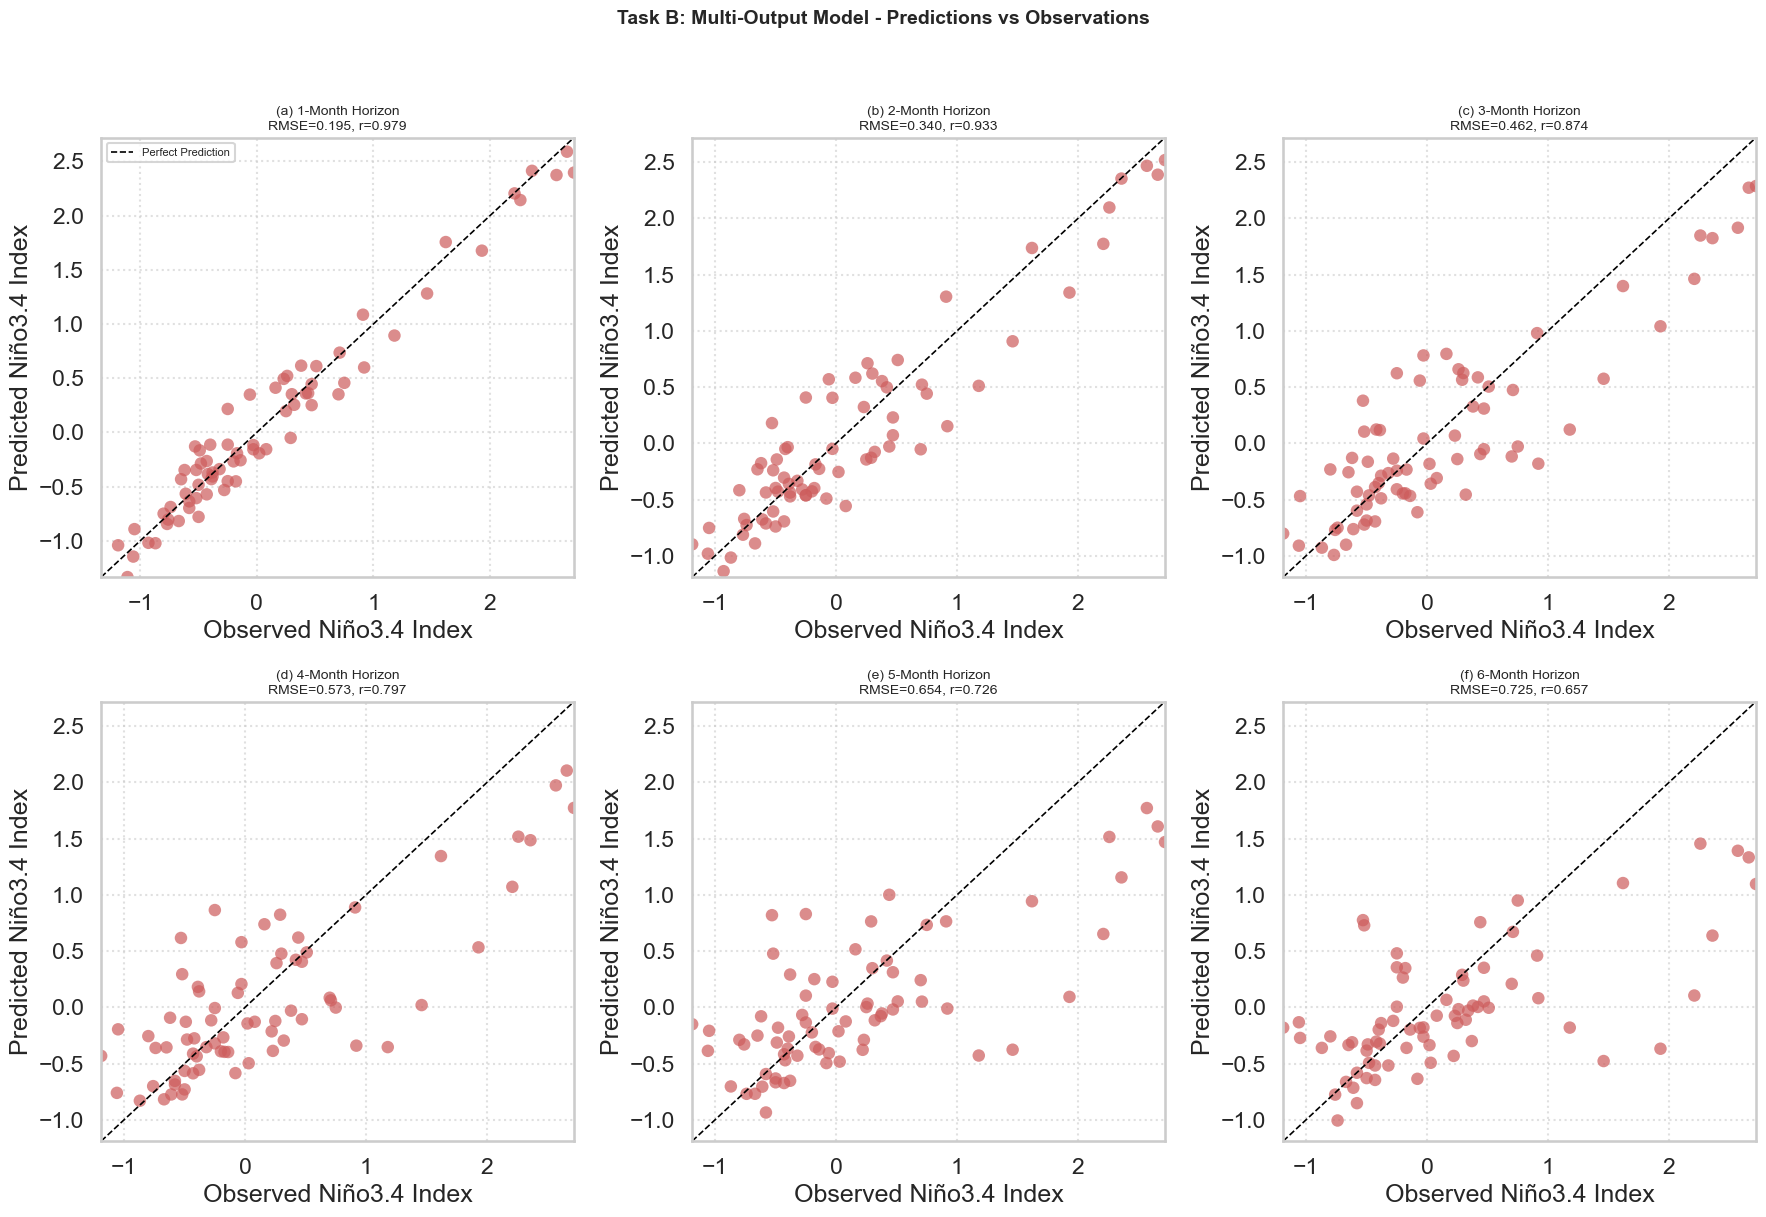

In [172]:
# ---------- (t) Scatter Plots: Predicted vs Observed ----------

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

titles = [
    "(a) 1-Month Horizon",
    "(b) 2-Month Horizon",
    "(c) 3-Month Horizon",
    "(d) 4-Month Horizon",
    "(e) 5-Month Horizon",
    "(f) 6-Month Horizon"
]

for i, ax in enumerate(axes):
    # scatter plot
    ax.scatter(
        y_true[:, i], y_pred[:, i],
        color="indianred", alpha=0.7, edgecolor="none"
    )

    # reference line y=x
    min_val = min(y_true[:, i].min(), y_pred[:, i].min())
    max_val = max(y_true[:, i].max(), y_pred[:, i].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=1.2, label="Perfect Prediction")

    # labels and title
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)
    ax.set_title(f"{titles[i]}\nRMSE={rmse_list_B[i]:.3f}, r={r_list_B[i]:.3f}", fontsize=10)
    ax.set_xlabel("Observed Niño3.4 Index")
    ax.set_ylabel("Predicted Niño3.4 Index")
    ax.grid(True, linestyle=":", alpha=0.6)

    if i == 0:
        ax.legend(loc="upper left", fontsize=8)

plt.suptitle("Task B: Multi-Output Model - Predictions vs Observations", fontsize=14, weight="bold", y=1.02)
plt.tight_layout()
plt.show()

## 5.3 Model Improvements
### (u) Propose and implement a strategy that could improve the performance of such a multi-output model.
    Hint: think about modifying the loss function so that it gives different weights to different outputs, or combining errors in a customised way instead of using the default mean squared error.
    Note: Save this improved model separately from your standard Task B model.

In [173]:
# ---------- Improved Adaptive Weighted Training Function ----------
def train_multi_output_weighted(epochs=1000, lr=1e-4, batch_size=32, patience=10):
    # Data loading
    train_dataset = TensorDataset(train_X, train_y)
    val_dataset = TensorDataset(val_X, val_y)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Initialize model and optimizer
    model = MultiOutputNinoNet(train_X.shape[1], output_dim=train_y.shape[1]).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

    # Initial uniform weights (to be updated dynamically)
    weights = torch.ones(train_y.shape[1], dtype=torch.float32).to(device)

    # Weighted MSE Loss
    def weighted_mse_loss(pred, target, weights):
        mse = (pred - target) ** 2
        return torch.mean(mse * weights)  # Broadcasting multiplication aligns dimensions automatically

    # Early stopping initialization
    train_losses, val_losses = [], []
    best_val_loss = float("inf")
    patience_counter = 0
    best_state = None
    prev_weights = None  # Defined outside the loop to avoid scope issues

    # ---------- Main Training Loop ----------
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(Xb)
            loss = weighted_mse_loss(out, yb, weights)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() * Xb.size(0)

        avg_train_loss = total_train_loss / len(train_loader.dataset)

        # ---------- Validation Phase ----------
        model.eval()
        total_val_loss = 0
        all_pred, all_true = [], []
        with torch.no_grad():
            for Xb, yb in val_loader:
                Xb, yb = Xb.to(device), yb.to(device)
                out = model(Xb)
                all_pred.append(out.cpu())
                all_true.append(yb.cpu())
                loss = weighted_mse_loss(out, yb, weights)
                total_val_loss += loss.item() * Xb.size(0)
        avg_val_loss = total_val_loss / len(val_loader.dataset)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        # ---------- Dynamic Weight Adjustment ----------
        y_pred = torch.cat(all_pred, dim=0).numpy()
        y_true = torch.cat(all_true, dim=0).numpy()

        rmse_list = np.sqrt(np.mean((y_pred - y_true) ** 2, axis=0))

        # Inverse proportional weighting: larger RMSE → larger weight
        inv_rmse = rmse_list / (rmse_list.mean() + 1e-6)

        # Exponential smoothing to prevent oscillation
        if prev_weights is not None:
            inv_rmse = 0.9 * prev_weights + 0.1 * inv_rmse

        # Time trend factor: gently encourage longer horizons
        time_factor = np.linspace(1.0, 1.2, num=len(inv_rmse))
        weights_np = inv_rmse * time_factor

        # Normalize weights so mean = 1 (prevents overall scale drift)
        weights_np = weights_np / weights_np.mean()

        # Convert to torch tensor for next iteration
        weights = torch.tensor(weights_np, dtype=torch.float32).to(device)
        prev_weights = inv_rmse.copy()

        # ---------- Early Stopping ----------
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}
        else:
            patience_counter += 1

        if (epoch + 1) % 5 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] "
                  f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
            print(f"    Dynamic weights: {weights_np.round(3)}")

        if patience_counter >= patience:
            print(f" Early stopping at epoch {epoch+1}")
            break

    # ---------- Model Saving ----------
    model.load_state_dict(best_state)
    torch.save(model.state_dict(), "nino_model_multi_output_weighted.pth")
    print("Model saved as：nino_model_multi_output_weighted.pth")

    return model, train_losses, val_losses


# ---------- Training Script ----------
print("\n===== Training Adaptive Weighted Multi-Output Model =====")
model_weighted, _, _ = train_multi_output_weighted(
    epochs=1000, lr=1e-4, batch_size=32, patience=10
)


===== Training Adaptive Weighted Multi-Output Model =====
Epoch [5/1000] Train Loss: 0.9632, Val Loss: 0.8972
    Dynamic weights: [0.902 0.935 0.992 1.044 1.023 1.104]
Epoch [10/1000] Train Loss: 0.8838, Val Loss: 0.8230
    Dynamic weights: [0.893 0.936 0.985 1.05  1.024 1.113]
Epoch [15/1000] Train Loss: 0.7769, Val Loss: 0.7260
    Dynamic weights: [0.867 0.936 0.977 1.056 1.029 1.134]
Epoch [20/1000] Train Loss: 0.6732, Val Loss: 0.6303
    Dynamic weights: [0.819 0.928 0.969 1.064 1.047 1.172]
Epoch [25/1000] Train Loss: 0.5841, Val Loss: 0.5638
    Dynamic weights: [0.755 0.908 0.962 1.072 1.082 1.221]
Epoch [30/1000] Train Loss: 0.5345, Val Loss: 0.5267
    Dynamic weights: [0.693 0.884 0.953 1.078 1.121 1.271]
Epoch [35/1000] Train Loss: 0.5044, Val Loss: 0.5035
    Dynamic weights: [0.646 0.863 0.945 1.082 1.152 1.312]
Epoch [40/1000] Train Loss: 0.4791, Val Loss: 0.4847
    Dynamic weights: [0.614 0.848 0.937 1.084 1.174 1.343]
Epoch [45/1000] Train Loss: 0.4563, Val Loss: 

In [ ]:
"""
epochs=1000, lr=1e-4, batch_size=32, patience=10

input_dim, output_dim=6
    nn.Linear(input_dim, 64),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, output_dim)
"""

Horizon 1: RMSE = 0.2014, Pearson r = 0.9776
Horizon 2: RMSE = 0.3545, Pearson r = 0.9294
Horizon 3: RMSE = 0.4569, Pearson r = 0.8760
Horizon 4: RMSE = 0.5657, Pearson r = 0.8023
Horizon 5: RMSE = 0.6449, Pearson r = 0.7350
Horizon 6: RMSE = 0.7178, Pearson r = 0.6639


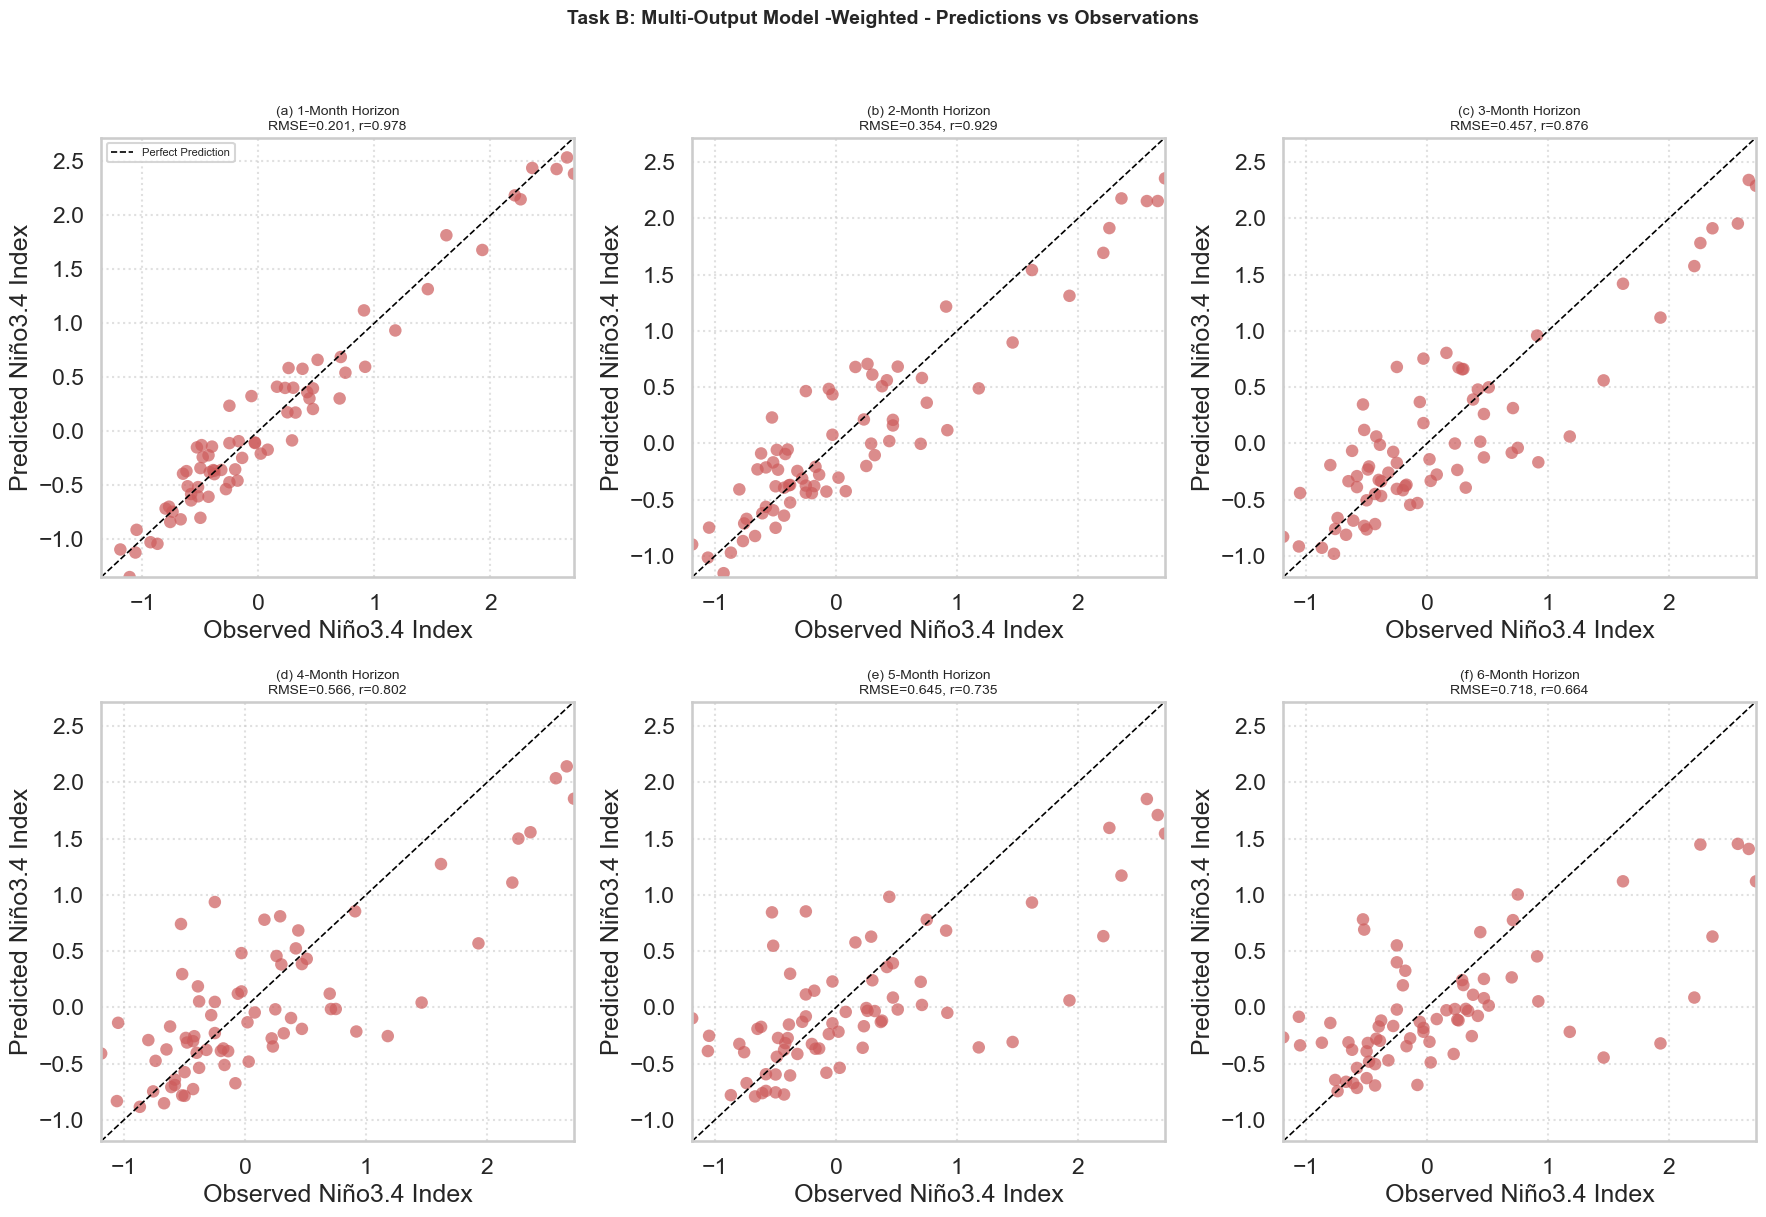

In [174]:
# ---------- Load Model and Predict ----------
model = MultiOutputNinoNet(input_dim=X_test_tensor.shape[1])
model.load_state_dict(torch.load("nino_model_multi_output_weighted.pth", map_location="cpu"))
model.eval()

with torch.no_grad():
    y_pred = model(X_test_tensor).cpu().numpy()  # shape (N, 6)

# ---------- Inverse Transform Predictions and True Values ----------
y_pred = scaler_y.inverse_transform(y_pred)
y_true = scaler_y.inverse_transform(test_y_scaled)  # ← Ensure this is test_y_scaled

# ---------- Compute RMSE and Pearson r for Each Prediction Step ----------

rmse_weighted, r_weighted = [], []
for i in range(6):
    rmse = np.sqrt(mean_squared_error(y_true[:, i], y_pred[:, i]))
    r, _ = pearsonr(y_true[:, i], y_pred[:, i])
    rmse_weighted.append(rmse)
    r_weighted.append(r)
    print(f"Horizon {i+1}: RMSE = {rmse:.4f}, Pearson r = {r:.4f}")

# ---------- Scatter Plots: Predicted vs Observed ----------

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

titles = [
    "(a) 1-Month Horizon",
    "(b) 2-Month Horizon",
    "(c) 3-Month Horizon",
    "(d) 4-Month Horizon",
    "(e) 5-Month Horizon",
    "(f) 6-Month Horizon"
]

for i, ax in enumerate(axes):
    # scatter plot
    ax.scatter(
        y_true[:, i], y_pred[:, i],
        color="indianred", alpha=0.7, edgecolor="none"
    )

    # reference line y=x
    min_val = min(y_true[:, i].min(), y_pred[:, i].min())
    max_val = max(y_true[:, i].max(), y_pred[:, i].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=1.2, label="Perfect Prediction")

    # labels and title
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)
    ax.set_title(f"{titles[i]}\nRMSE={rmse_weighted[i]:.3f}, r={r_weighted[i]:.3f}", fontsize=10)
    ax.set_xlabel("Observed Niño3.4 Index")
    ax.set_ylabel("Predicted Niño3.4 Index")
    ax.grid(True, linestyle=":", alpha=0.6)

    if i == 0:
        ax.legend(loc="upper left", fontsize=8)

plt.suptitle("Task B: Multi-Output Model -Weighted - Predictions vs Observations", fontsize=14, weight="bold", y=1.02)
plt.tight_layout()
plt.show()

# 6 Comparison and Analysis

## 6.1 Comparison Requirements
### (w) Create a comparison table showing RMSE and correlation coefficients for all 6 forecast horizons, comparing: (1) Task A individual models, (2) Task B standard model(baseline), and (3) Task B improved model with weighted loss. Include average performance and calculate relative improvement percentages using Task B standard model as the baseline reference

In [175]:
# ---------- (w) Model Comparison Table ----------

# ---------- Task A: Single-output models (baseline per horizon) ----------
taskA_results = results_df_A.copy()

# ---------- Task A: Transfer learning model (only for t+6 horizon) ----------
taskA_transfer_rmse = [np.nan]*5 + [rmse_transfer]
taskA_transfer_r = [np.nan]*5 + [corr_transfer]

# ---------- Task B: Multi-output models ----------
taskB_standard_rmse = rmse_list_B.copy()
taskB_standard_r = r_list_B.copy()

# Weighted (adaptive) multi-output model results
taskB_weighted_rmse = rmse_weighted.copy()
taskB_weighted_r = r_weighted.copy()

# ---------- Build Comparison Table ----------
horizons = np.arange(1, 7)
comparison_df = pd.DataFrame({
    "Horizon": horizons,
    "Task A RMSE": taskA_results["RMSE"].tolist(),
    "Task A r": taskA_results["Pearson r"].tolist(),
    "Task A Transfer RMSE": taskA_transfer_rmse,
    "Task A Transfer r": taskA_transfer_r,
    "Task B Standard RMSE": taskB_standard_rmse,
    "Task B Standard r": taskB_standard_r,
    "Task B Weighted RMSE": taskB_weighted_rmse,
    "Task B Weighted r": taskB_weighted_r
})

# ---------- Add Average Row ----------
avg_row = pd.DataFrame({
    "Horizon": ["Average"],
    "Task A RMSE": [np.nanmean(comparison_df["Task A RMSE"])],
    "Task A r": [np.nanmean(comparison_df["Task A r"])],
    "Task A Transfer RMSE": [np.nanmean([x for x in taskA_transfer_rmse if not np.isnan(x)])],
    "Task A Transfer r": [np.nanmean([x for x in taskA_transfer_r if not np.isnan(x)])],
    "Task B Standard RMSE": [np.mean(taskB_standard_rmse)],
    "Task B Standard r": [np.mean(taskB_standard_r)],
    "Task B Weighted RMSE": [np.mean(taskB_weighted_rmse)],
    "Task B Weighted r": [np.mean(taskB_weighted_r)]
})
comparison_df = pd.concat([comparison_df, avg_row], ignore_index=True)

# ---------- Compute Relative Improvements ----------
comparison_df["Weighted RMSE Improvement (%)"] = 100 * (
    (comparison_df["Task B Standard RMSE"] - comparison_df["Task B Weighted RMSE"])
    / comparison_df["Task B Standard RMSE"]
)
comparison_df["Weighted r Improvement (%)"] = 100 * (
    (comparison_df["Task B Weighted r"] - comparison_df["Task B Standard r"])
    / comparison_df["Task B Standard r"]
)

# ---------- Display Results ----------
pd.set_option("display.float_format", "{:.4f}".format)
print(" Model Comparison Table (4 Models, including Task A Transfer Learning for t+6):")
print(comparison_df.to_string(index=False))

 Model Comparison Table (4 Models, including Task A Transfer Learning for t+6):
Horizon  Task A RMSE  Task A r  Task A Transfer RMSE  Task A Transfer r  Task B Standard RMSE  Task B Standard r  Task B Weighted RMSE  Task B Weighted r  Weighted RMSE Improvement (%)  Weighted r Improvement (%)
      1       0.2047    0.9771                   NaN                NaN                0.1951             0.9790                0.2014             0.9776                        -3.1889                     -0.1453
      2       0.3645    0.9241                   NaN                NaN                0.3395             0.9335                0.3545             0.9294                        -4.3929                     -0.4346
      3       0.4822    0.8604                   NaN                NaN                0.4619             0.8739                0.4569             0.8760                         1.0738                      0.2464
      4       0.5702    0.7968                   NaN                

### (x) Generate comparison visualisations showing RMSE and correlation trends across forecast horizons for both approaches, as shown in Figu

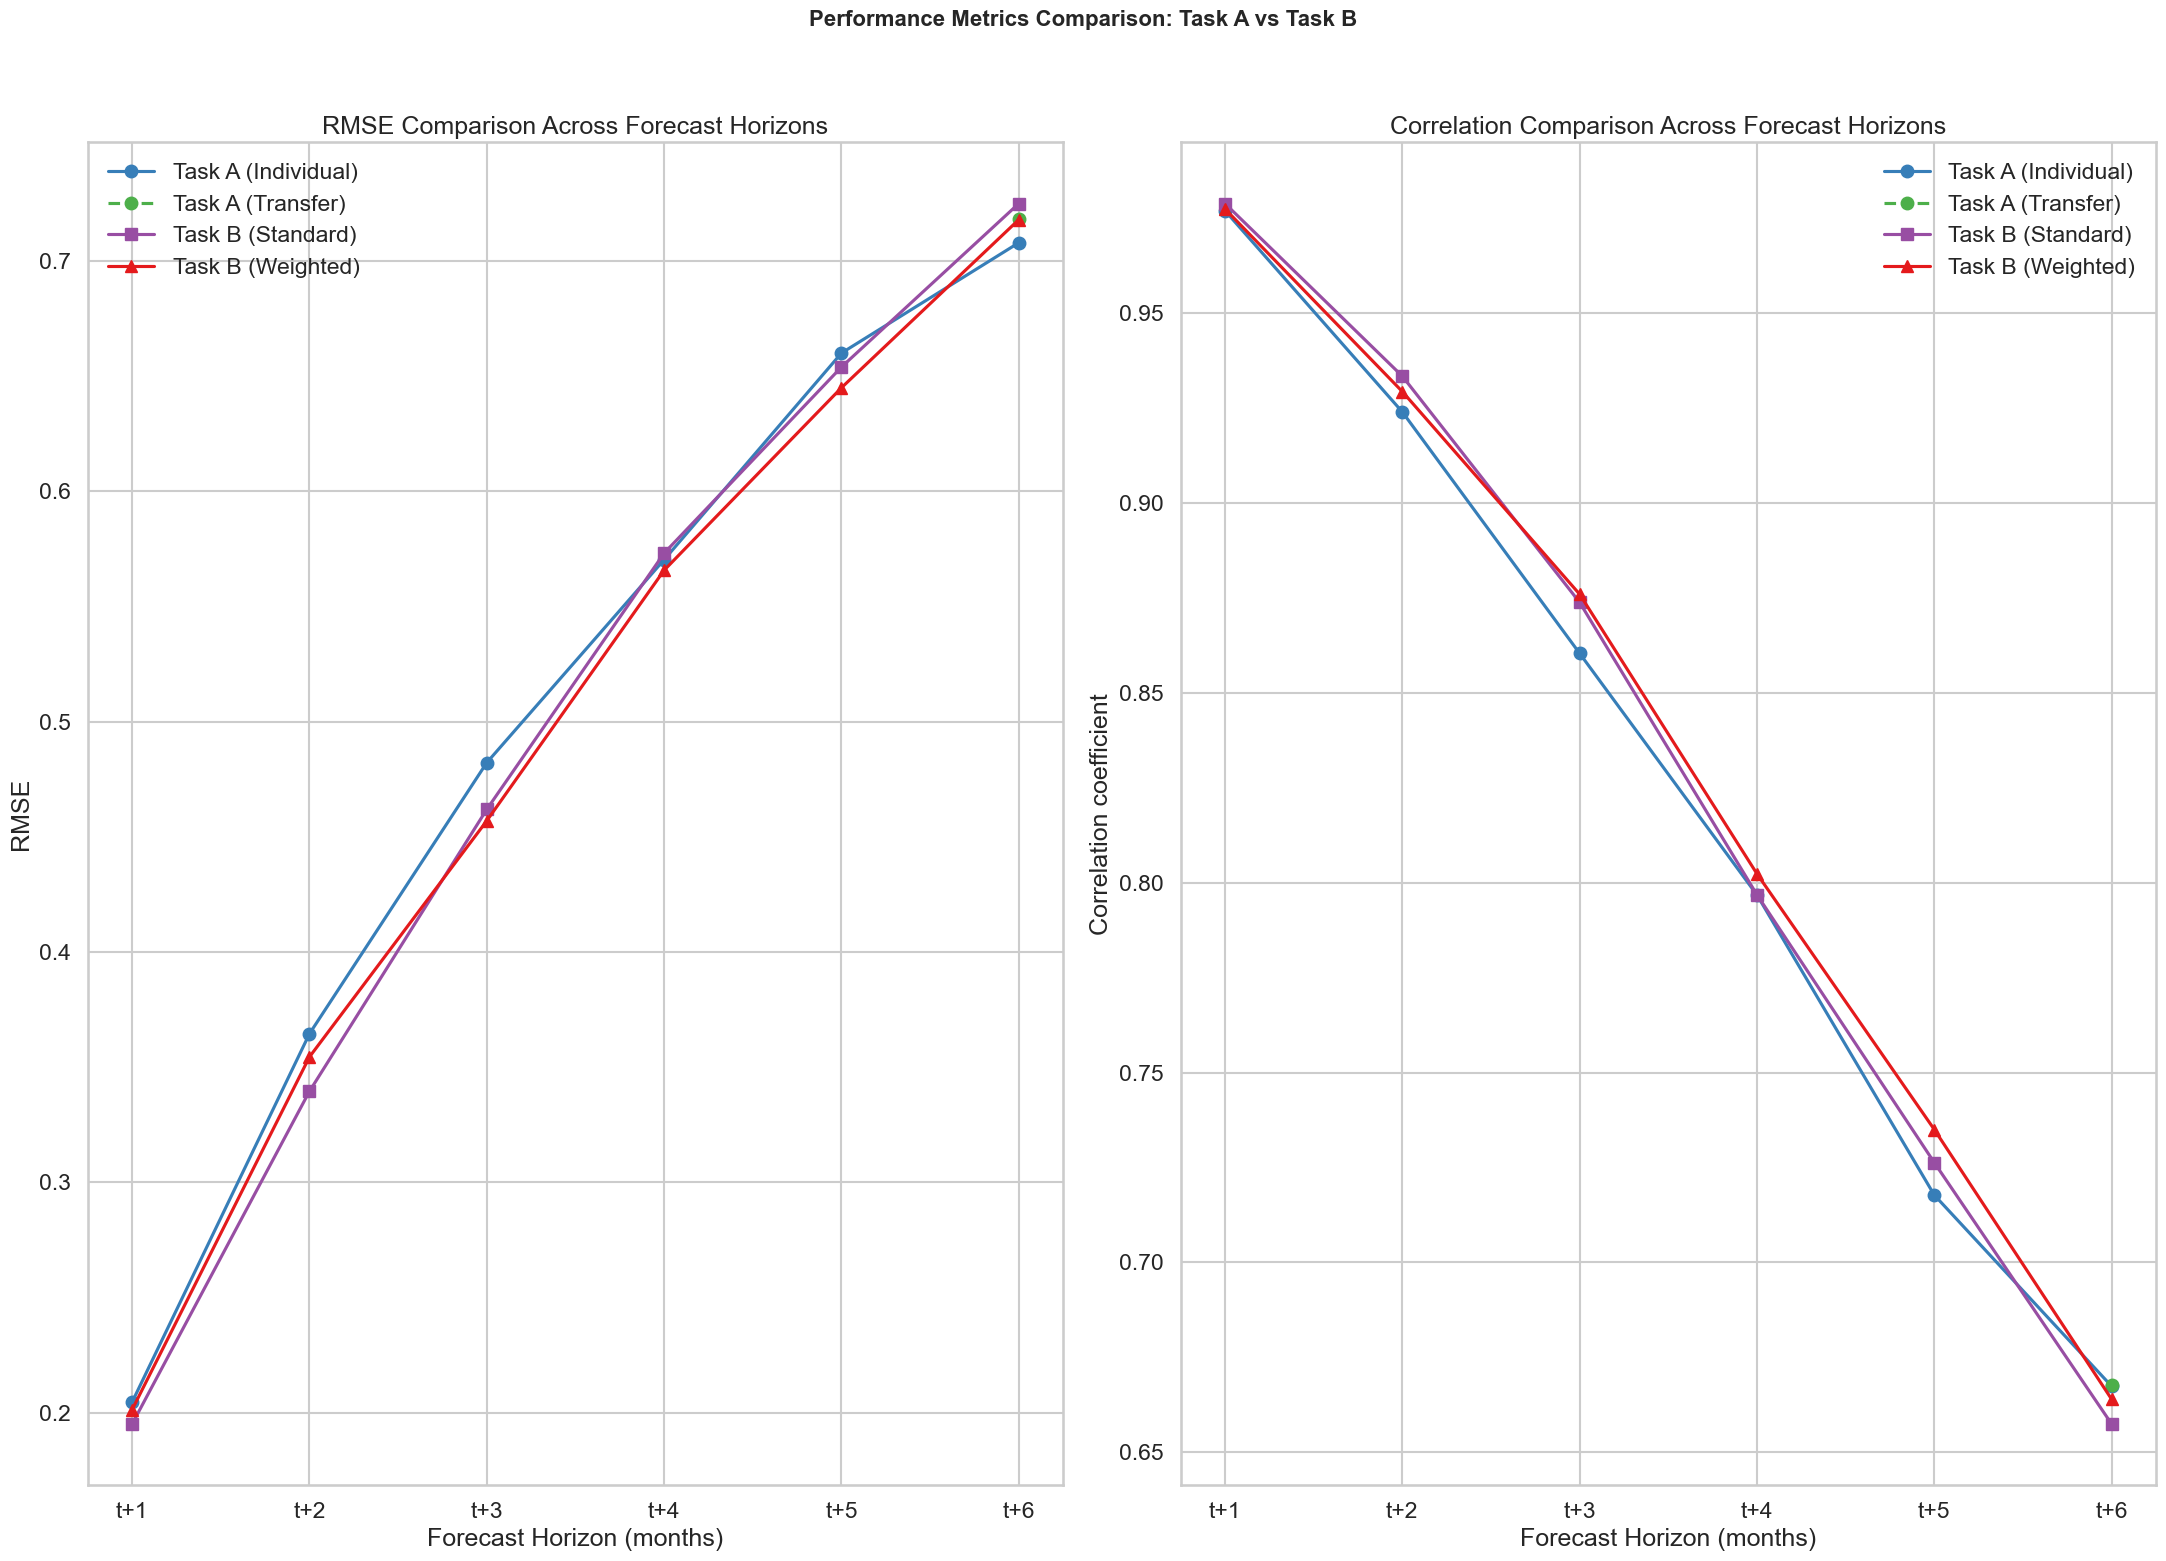

In [176]:
# ----------------------------
# (x) Generate comparison visualisations
# ----------------------------

# color palette
palette = {
    "Task A (Individual)": "#377eb8",
    "Task A (Transfer)": "#4daf4a",
    "Task B (Standard)": "#984ea3",     
    "Task B (Weighted)": "#e41a1c"
}

# Extract data
horizons = np.arange(1, 7)

taskA_rmse = comparison_df["Task A RMSE"][:-1]
taskA_r = comparison_df["Task A r"][:-1]
taskA_transfer_rmse = comparison_df["Task A Transfer RMSE"][:-1]
taskA_transfer_r = comparison_df["Task A Transfer r"][:-1]
taskB_standard_rmse = comparison_df["Task B Standard RMSE"][:-1]
taskB_standard_r = comparison_df["Task B Standard r"][:-1]
taskB_weighted_rmse = comparison_df["Task B Weighted RMSE"][:-1]
taskB_weighted_r = comparison_df["Task B Weighted r"][:-1]

# ---------- Plotting ----------
plt.figure(figsize=(22, 16))
sns.set_style("whitegrid")
sns.set_context("talk")

# ---- subplot1: RMSE ----
plt.subplot(1, 2, 1)
plt.plot(horizons, taskA_rmse, 'o-', color=palette["Task A (Individual)"], label="Task A (Individual)")
plt.plot(horizons, taskA_transfer_rmse, 'o--', color=palette["Task A (Transfer)"], label="Task A (Transfer)")
plt.plot(horizons, taskB_standard_rmse, 's-', color=palette["Task B (Standard)"], label="Task B (Standard)")
plt.plot(horizons, taskB_weighted_rmse, '^-', color=palette["Task B (Weighted)"], label="Task B (Weighted)")

plt.xlabel("Forecast Horizon (months)")
plt.ylabel("RMSE")
plt.title("RMSE Comparison Across Forecast Horizons")
plt.xticks(horizons, [f"t+{i}" for i in horizons])
plt.legend(frameon=False, loc="upper left")

# ---- subplot2: Correlation ----
plt.subplot(1, 2, 2)
plt.plot(horizons, taskA_r, 'o-', color=palette["Task A (Individual)"], label="Task A (Individual)")
plt.plot(horizons, taskA_transfer_r, 'o--', color=palette["Task A (Transfer)"], label="Task A (Transfer)")
plt.plot(horizons, taskB_standard_r, 's-', color=palette["Task B (Standard)"], label="Task B (Standard)")
plt.plot(horizons, taskB_weighted_r, '^-', color=palette["Task B (Weighted)"], label="Task B (Weighted)")

plt.xlabel("Forecast Horizon (months)")
plt.ylabel("Correlation coefficient")
plt.title("Correlation Comparison Across Forecast Horizons")
plt.xticks(horizons, [f"t+{i}" for i in horizons])
plt.legend(frameon=False, loc="upper right")

# ---- title ----
plt.suptitle("Performance Metrics Comparison: Task A vs Task B", fontsize=16, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Task C Evaluation Cell in Notebook
include a dedicated evaluation cell (or cells) at the end that can load the hidden test dataset (Nino3.4 data hidden.csv), load all your trained models and scalers, and evaluate them on this hidden dataset. This cell should print clear results showing RMSE and correlation metrics for all Task A and Task B models

In [117]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.optim as optim
import joblib
import random
import matplotlib.pyplot as plt
import torch.nn as nn
from scipy.stats import pearsonr
import math
from sklearn.metrics import mean_squared_error
import seaborn as sns

In [ ]:
# ---------- 1. load hidden data ----------
# Example evaluation structure (adapt to your implementation)
hidden_data = pd.read_csv("Nino3.4_data_hidden.csv")

# ---------- 2. Define input and target features ----------
input_features = ["nino_tminus2", "nino_tminus1", "nino_t"]
target_features = ["nino_tplus1", "nino_tplus2", "nino_tplus3", "nino_tplus4", "nino_tplus5", "nino_tplus6"]

# ---------- 3. Add same time features ----------
hidden_data["month_sin"] = np.sin(2 * np.pi * hidden_data["month"] / 12)
hidden_data["month_cos"] = np.cos(2 * np.pi * hidden_data["month"] / 12)
input_features_extended = input_features + ["month_sin", "month_cos"]

# ---------- 4. Load saved scalers ----------
scaler_X = joblib.load("scaler_X.pkl")
scaler_y = joblib.load("scaler_y.pkl")
# no re fit，just transform
X_features = ['nino_tminus2', 'nino_tminus1', 'nino_t', 'month_sin', 'month_cos']
y_targets = ['nino_tplus1', 'nino_tplus2', 'nino_tplus3', 
             'nino_tplus4', 'nino_tplus5', 'nino_tplus6']


# ============= TASK A EVALUATION =============


# ---------- 5. Scale inputs ----------
X_hidden_scaled = scaler_X.transform(hidden_data[X_features])
X_hidden_tensor = torch.tensor(X_hidden_scaled, dtype=torch.float32)
# Keep original targets (for inverse scaling comparison)
y_hidden_orig = hidden_data[y_targets].values
y_hidden_scaled = scaler_y.transform(hidden_data[target_features])

# ---------- 6. Define model structure (must match training exactly) ----------
class NinoNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, dropout=0.1):
        super(NinoNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.model(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------- 7. Prepare inverse scaling parameters ----------
means = scaler_y.mean_
scales = scaler_y.scale_

# ---------- 8. Evaluate each Task A model ----------
print("EVALUATION RESULTS ON HIDDEN DATASET (Task A)")
print()
results = []

for h in range(1, 7):
    model = NinoNet(input_dim=X_hidden_tensor.shape[1]).to(device)
    model.load_state_dict(torch.load(f"nino_model_tplus{h}.pth", map_location=device))
    model.eval()

    with torch.no_grad():
        preds_scaled = model(X_hidden_tensor.to(device)).cpu().numpy().reshape(-1, 1)

    # ---------- Inverse scaling ----------
    col_idx = h - 1
    preds_orig = preds_scaled * scales[col_idx] + means[col_idx]
    true_orig = y_hidden_orig[:, col_idx].reshape(-1, 1)

    rmse = math.sqrt(mean_squared_error(true_orig, preds_orig))
    corr, _ = pearsonr(true_orig.flatten(), preds_orig.flatten())

    results.append({
        "Horizon (month ahead)": h,
        "RMSE": rmse,
        "Pearson r": corr
    })

# ---------- 9. Compile results ----------
results_df_A = pd.DataFrame(results)
print(results_df_A.to_string(index=False))
print("=" * 60)


# ============= TASK A TRANSFER LEARNING EVALUATION =============


print("EVALUATION RESULTS ON HIDDEN DATASET (Task A-transfer learning)")
print()

# ---------- 1. Prepare inverse scaling parameters for tplus6 ----------
col_idx = list(scaler_y.feature_names_in_).index("nino_tplus6")


# ---------- 2. Load transfer learning model ----------
model_transfer = NinoNet(input_dim=X_hidden_tensor.shape[1]).to(device)
model_transfer.load_state_dict(torch.load("nino_model_transfer_tplus6.pth", map_location=device))
model_transfer.eval()

# ---------- 3. Predict ----------
with torch.no_grad():
    y_pred_scaled = model_transfer(X_hidden_tensor.to(device)).cpu().numpy()  # (N,1)

# ---------- 4. Inverse scaling ----------
y_pred_orig = y_pred_scaled * scaler_y.scale_[col_idx] + scaler_y.mean_[col_idx]
y_true_orig = hidden_data[["nino_tplus6"]].values

# ---------- 5. Evaluate ----------
rmse_transfer = np.sqrt(mean_squared_error(y_true_orig, y_pred_orig))
corr_transfer, _ = pearsonr(y_true_orig.flatten(), y_pred_orig.flatten())

print(f"tplus6 (Transfer): RMSE = {rmse_transfer:.4f}, Corr = {corr_transfer:.4f}")
print("=" * 60)


# ============= TASK B EVALUATION =============


# ---------- 1. Define model structure (must match training exactly) ----------
class MultiOutputNinoNet(nn.Module):
    def __init__(self, input_dim, output_dim=6):
        super(MultiOutputNinoNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, output_dim)
        )
    def forward(self, x):
        return self.model(x)

# ---------- 2. Load pre-trained model ----------
model = MultiOutputNinoNet(input_dim=X_hidden_tensor.shape[1])
model.load_state_dict(torch.load("nino_model_multi_output.pth", map_location="cpu"))
model.eval()

# ---------- 3. Predict ----------
with torch.no_grad():
    y_pred_scaled = model(X_hidden_tensor).cpu().numpy()

# ---------- 4. Inverse scaling ----------
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_hidden_scaled)

# ---------- 5. Compute metrics ----------
rmse_list_B, r_list_B = [], []
for i in range(6):
    rmse = np.sqrt(mean_squared_error(y_true[:, i], y_pred[:, i]))
    r, _ = pearsonr(y_true[:, i], y_pred[:, i])
    rmse_list_B.append(rmse)
    r_list_B.append(r)

results_df_B_hidden = pd.DataFrame({
    "Horizon (month ahead)": np.arange(1, 7),
    "RMSE": rmse_list_B,
    "Pearson r": r_list_B
})

print("Task B Hidden Test Performance:")
print(results_df_B_hidden.to_string(index=False))
print("=" * 60)


# ============= TASK B WEIGHTED EVALUATION =============


# ---------- 1. Load model and predict ----------
model = MultiOutputNinoNet(input_dim=X_hidden_tensor.shape[1])
model.load_state_dict(torch.load("nino_model_multi_output_weighted.pth", map_location="cpu"))
model.eval()

# ---------- 2. Predict ----------
with torch.no_grad():
    y_pred_scaled = model(X_hidden_tensor).cpu().numpy()  # shape (N, 6)

# ---------- 3. Inverse scaling ----------
y_pred_weighted = scaler_y.inverse_transform(y_pred_scaled)
y_true_weighted = scaler_y.inverse_transform(y_hidden_scaled)

# ---------- 4. Compute metrics ----------
rmse_list_B_weighted, r_list_B_weighted = [], []
for i in range(6):
    rmse = np.sqrt(mean_squared_error(y_true_weighted[:, i], y_pred_weighted[:, i]))
    r, _ = pearsonr(y_true_weighted[:, i], y_pred_weighted[:, i])
    rmse_list_B_weighted.append(rmse)
    r_list_B_weighted.append(r)

results_df_B_hidden_weighted = pd.DataFrame({
    "Horizon (month ahead)": np.arange(1, 7),
    "RMSE": rmse_list_B_weighted,
    "Pearson r": r_list_B_weighted
})

print("Task B Weighted Hidden Test Performance:")
print(results_df_B_hidden_weighted.to_string(index=False))
print("=" * 60)



EVALUATION RESULTS ON HIDDEN DATASET (Task A)

 Horizon (month ahead)   RMSE  Pearson r
                     1 0.2303     0.9652
                     2 0.3579     0.9134
                     3 0.4347     0.8685
                     4 0.4986     0.8224
                     5 0.5480     0.7804
                     6 0.5977     0.7314
EVALUATION RESULTS ON HIDDEN DATASET (Task A-transfer learning)

tplus6 (Transfer): RMSE = 0.6087, Corr = 0.7203
Task B Hidden Test Performance:
 Horizon (month ahead)   RMSE  Pearson r
                     1 0.2378     0.9629
                     2 0.3584     0.9132
                     3 0.4371     0.8670
                     4 0.4978     0.8234
                     5 0.5558     0.7731
                     6 0.6159     0.7122
Task B Weighted Hidden Test Performance:
 Horizon (month ahead)   RMSE  Pearson r
                     1 0.2472     0.9598
                     2 0.3688     0.9077
                     3 0.4428     0.8633
                     4 0.5015

📊 Model Comparison Table (4 Models, including Task A Transfer Learning for t+6):
Horizon  Task A RMSE  Task A r  Task A Transfer RMSE  Task A Transfer r  Task B Standard RMSE  Task B Standard r  Task B Weighted RMSE  Task B Weighted r  Weighted RMSE Improvement (%)  Weighted r Improvement (%)
      1       0.2047    0.9771                   NaN                NaN                0.1951             0.9790                0.2472             0.9598                       -26.6665                     -1.9602
      2       0.3645    0.9241                   NaN                NaN                0.3395             0.9335                0.3688             0.9077                        -8.6130                     -2.7595
      3       0.4822    0.8604                   NaN                NaN                0.4619             0.8739                0.4428             0.8633                         4.1448                     -1.2139
      4       0.5702    0.7968                   NaN               

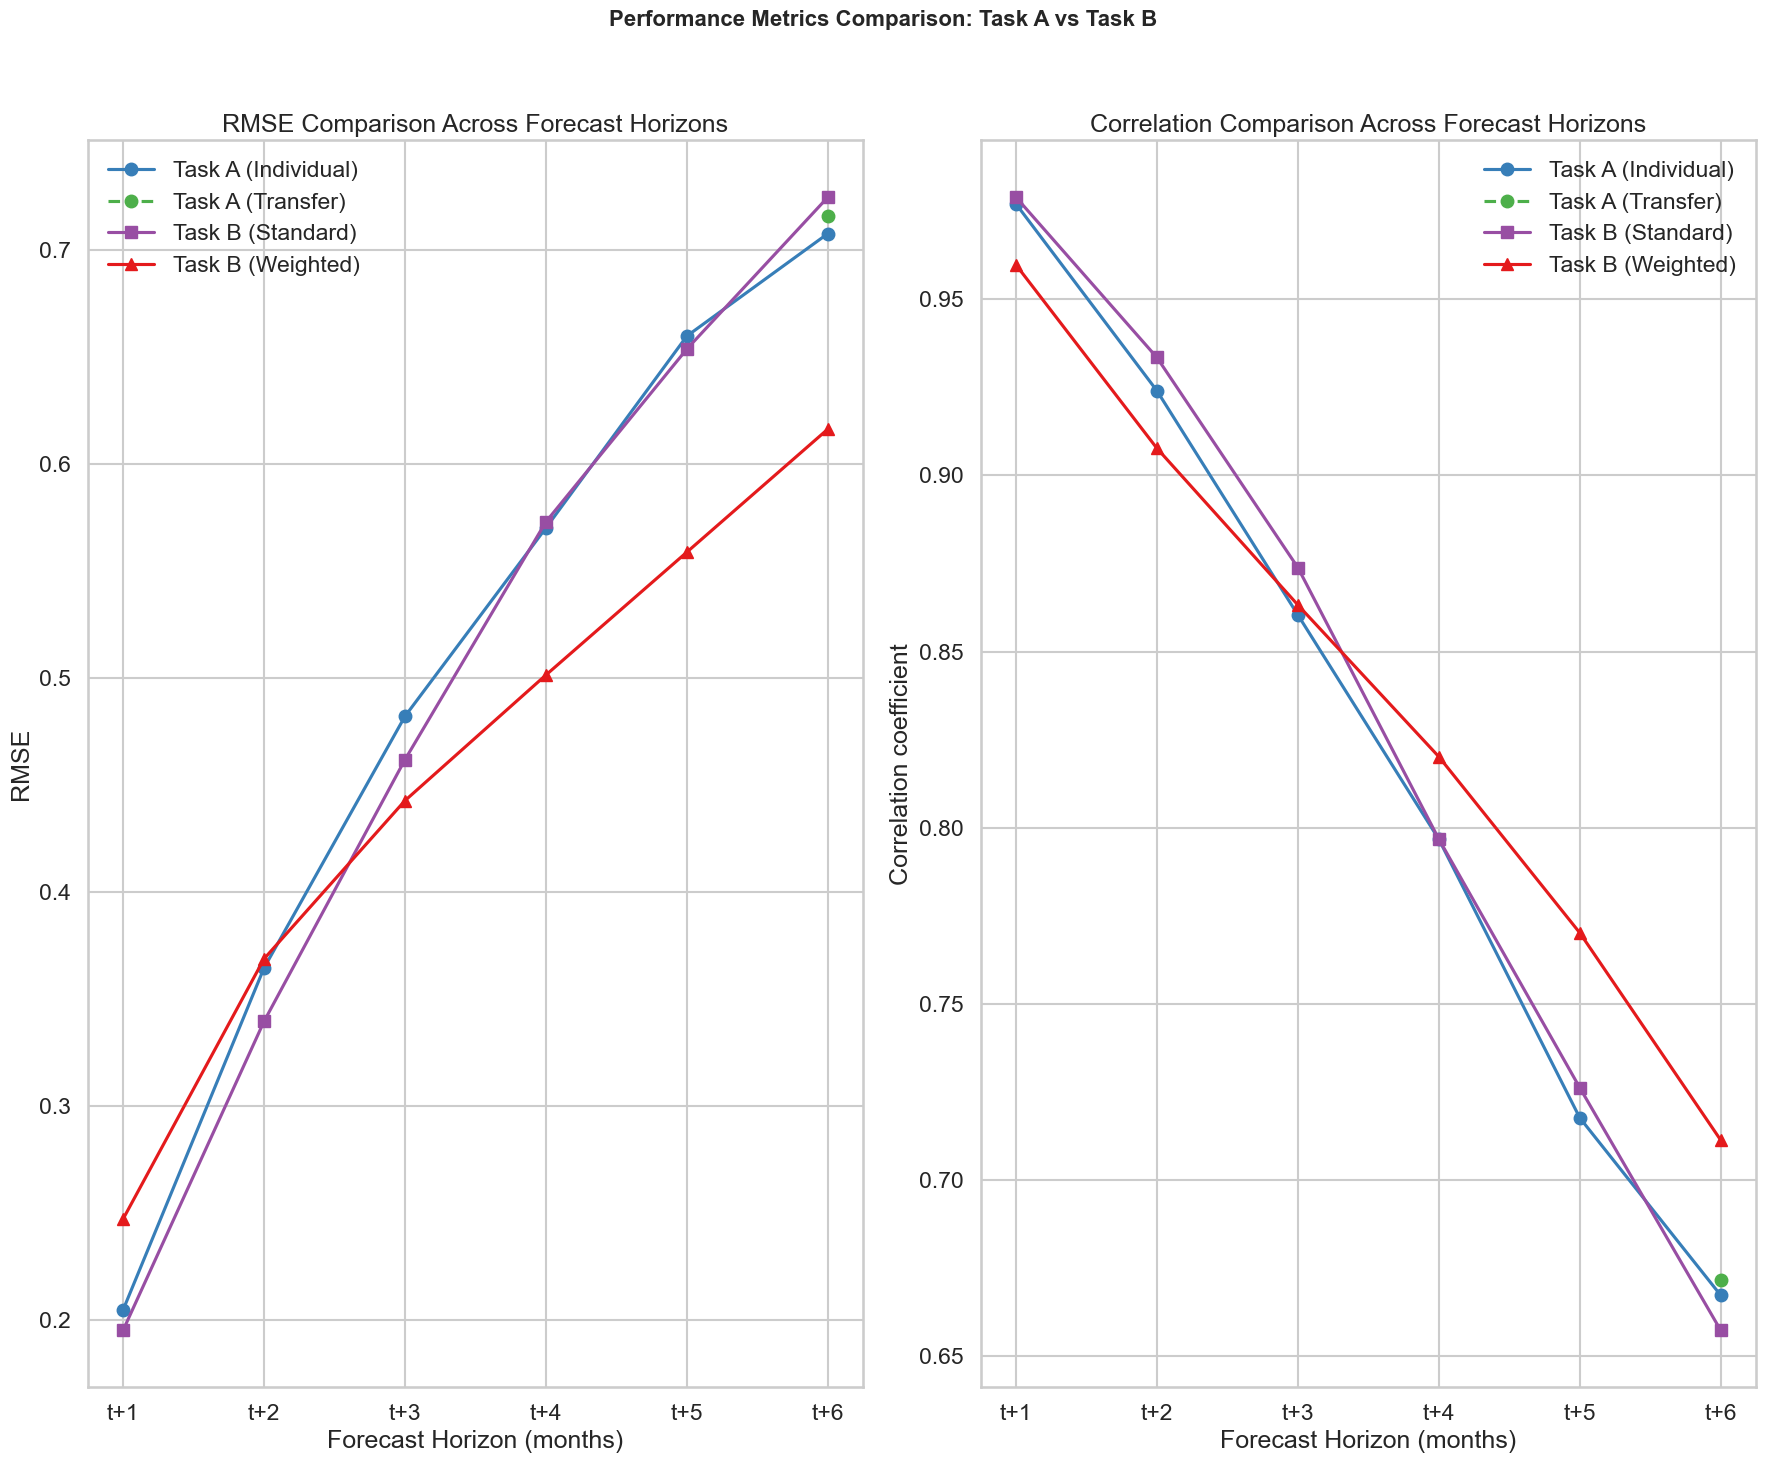

In [ ]:
# ============= SUMMARY TABLE ON HIDDEN DATASET =============

# ---------- Task A: Single-output models (baseline per horizon) ----------
taskA_results = results_df_A.copy()  # Each element in 'results_df_A' corresponds to a model predicting t+1, t+2, ..., t+6 separately.

# ---------- Task A: Transfer learning model (only for t+6 horizon) ----------
taskA_transfer_rmse = [np.nan]*5 + [rmse_transfer]
taskA_transfer_r = [np.nan]*5 + [corr_transfer]

# Task B standard multi-output model
taskB_standard_rmse = rmse_list_B.copy()   #  RMSE
taskB_standard_r = r_list_B.copy()         #  Pearson r

# Task B weighted multi-output model
taskB_weighted_rmse = rmse_list_B_weighted.copy()   #  RMSE
taskB_weighted_r = r_list_B_weighted.copy()         # Pearson r

horizons = np.arange(1, 7)
comparison_df = pd.DataFrame({
    "Horizon": horizons,
    "Task A RMSE": taskA_results["RMSE"].tolist(),
    "Task A r": taskA_results["Pearson r"].tolist(),
    "Task A Transfer RMSE": taskA_transfer_rmse,
    "Task A Transfer r": taskA_transfer_r,
    "Task B Standard RMSE": taskB_standard_rmse,
    "Task B Standard r": taskB_standard_r,
    "Task B Weighted RMSE": taskB_weighted_rmse,
    "Task B Weighted r": taskB_weighted_r
})

# ---------- Add Average Row ----------
avg_row = pd.DataFrame({
    "Horizon": ["Average"],
    "Task A RMSE": [np.nanmean(comparison_df["Task A RMSE"])],
    "Task A r": [np.nanmean(comparison_df["Task A r"])],
    "Task A Transfer RMSE": [np.nanmean([x for x in taskA_transfer_rmse if not np.isnan(x)])],
    "Task A Transfer r": [np.nanmean([x for x in taskA_transfer_r if not np.isnan(x)])],
    "Task B Standard RMSE": [np.mean(taskB_standard_rmse)],
    "Task B Standard r": [np.mean(taskB_standard_r)],
    "Task B Weighted RMSE": [np.mean(taskB_weighted_rmse)],
    "Task B Weighted r": [np.mean(taskB_weighted_r)]
})
comparison_df = pd.concat([comparison_df, avg_row], ignore_index=True)

# ---------- Compute Relative Improvements ----------
comparison_df["Weighted RMSE Improvement (%)"] = 100 * (
    (comparison_df["Task B Standard RMSE"] - comparison_df["Task B Weighted RMSE"])
    / comparison_df["Task B Standard RMSE"]
)
comparison_df["Weighted r Improvement (%)"] = 100 * (
    (comparison_df["Task B Weighted r"] - comparison_df["Task B Standard r"])
    / comparison_df["Task B Standard r"]
)

# 显示结果
pd.set_option("display.float_format", "{:.4f}".format)
print("Model Comparison Table (4 Models, including Task A Transfer Learning for t+6):")
print(comparison_df.to_string(index=False))

# ----------------------------
# (x) Generate comparison visualisations
# ----------------------------

# palette
palette = {
    "Task A (Individual)": "#377eb8",   
    "Task A (Transfer)": "#4daf4a",     
    "Task B (Standard)": "#984ea3",     
    "Task B (Weighted)": "#e41a1c"      
}

# Extract data
horizons = np.arange(1, 7)

taskA_rmse = comparison_df["Task A RMSE"][:-1]
taskA_r = comparison_df["Task A r"][:-1]
taskA_transfer_rmse = comparison_df["Task A Transfer RMSE"][:-1]
taskA_transfer_r = comparison_df["Task A Transfer r"][:-1]
taskB_standard_rmse = comparison_df["Task B Standard RMSE"][:-1]
taskB_standard_r = comparison_df["Task B Standard r"][:-1]
taskB_weighted_rmse = comparison_df["Task B Weighted RMSE"][:-1]
taskB_weighted_r = comparison_df["Task B Weighted r"][:-1]

# ---------- Plotting ----------
plt.figure(figsize=(18, 15))
sns.set_style("whitegrid")
sns.set_context("talk")

# ---- subplot1: RMSE ----
plt.subplot(1, 2, 1)
plt.plot(horizons, taskA_rmse, 'o-', color=palette["Task A (Individual)"], label="Task A (Individual)")
plt.plot(horizons, taskA_transfer_rmse, 'o--', color=palette["Task A (Transfer)"], label="Task A (Transfer)")
plt.plot(horizons, taskB_standard_rmse, 's-', color=palette["Task B (Standard)"], label="Task B (Standard)")
plt.plot(horizons, taskB_weighted_rmse, '^-', color=palette["Task B (Weighted)"], label="Task B (Weighted)")

plt.xlabel("Forecast Horizon (months)")
plt.ylabel("RMSE")
plt.title("RMSE Comparison Across Forecast Horizons")
plt.xticks(horizons, [f"t+{i}" for i in horizons])
plt.legend(frameon=False, loc="upper left")

# ---- subplot2: Correlation ----
plt.subplot(1, 2, 2)
plt.plot(horizons, taskA_r, 'o-', color=palette["Task A (Individual)"], label="Task A (Individual)")
plt.plot(horizons, taskA_transfer_r, 'o--', color=palette["Task A (Transfer)"], label="Task A (Transfer)")
plt.plot(horizons, taskB_standard_r, 's-', color=palette["Task B (Standard)"], label="Task B (Standard)")
plt.plot(horizons, taskB_weighted_r, '^-', color=palette["Task B (Weighted)"], label="Task B (Weighted)")

plt.xlabel("Forecast Horizon (months)")
plt.ylabel("Correlation coefficient")
plt.title("Correlation Comparison Across Forecast Horizons")
plt.xticks(horizons, [f"t+{i}" for i in horizons])
plt.legend(frameon=False, loc="upper right")

# ---- title ----
plt.suptitle("Performance Metrics Comparison: Task A vs Task B", fontsize=16, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

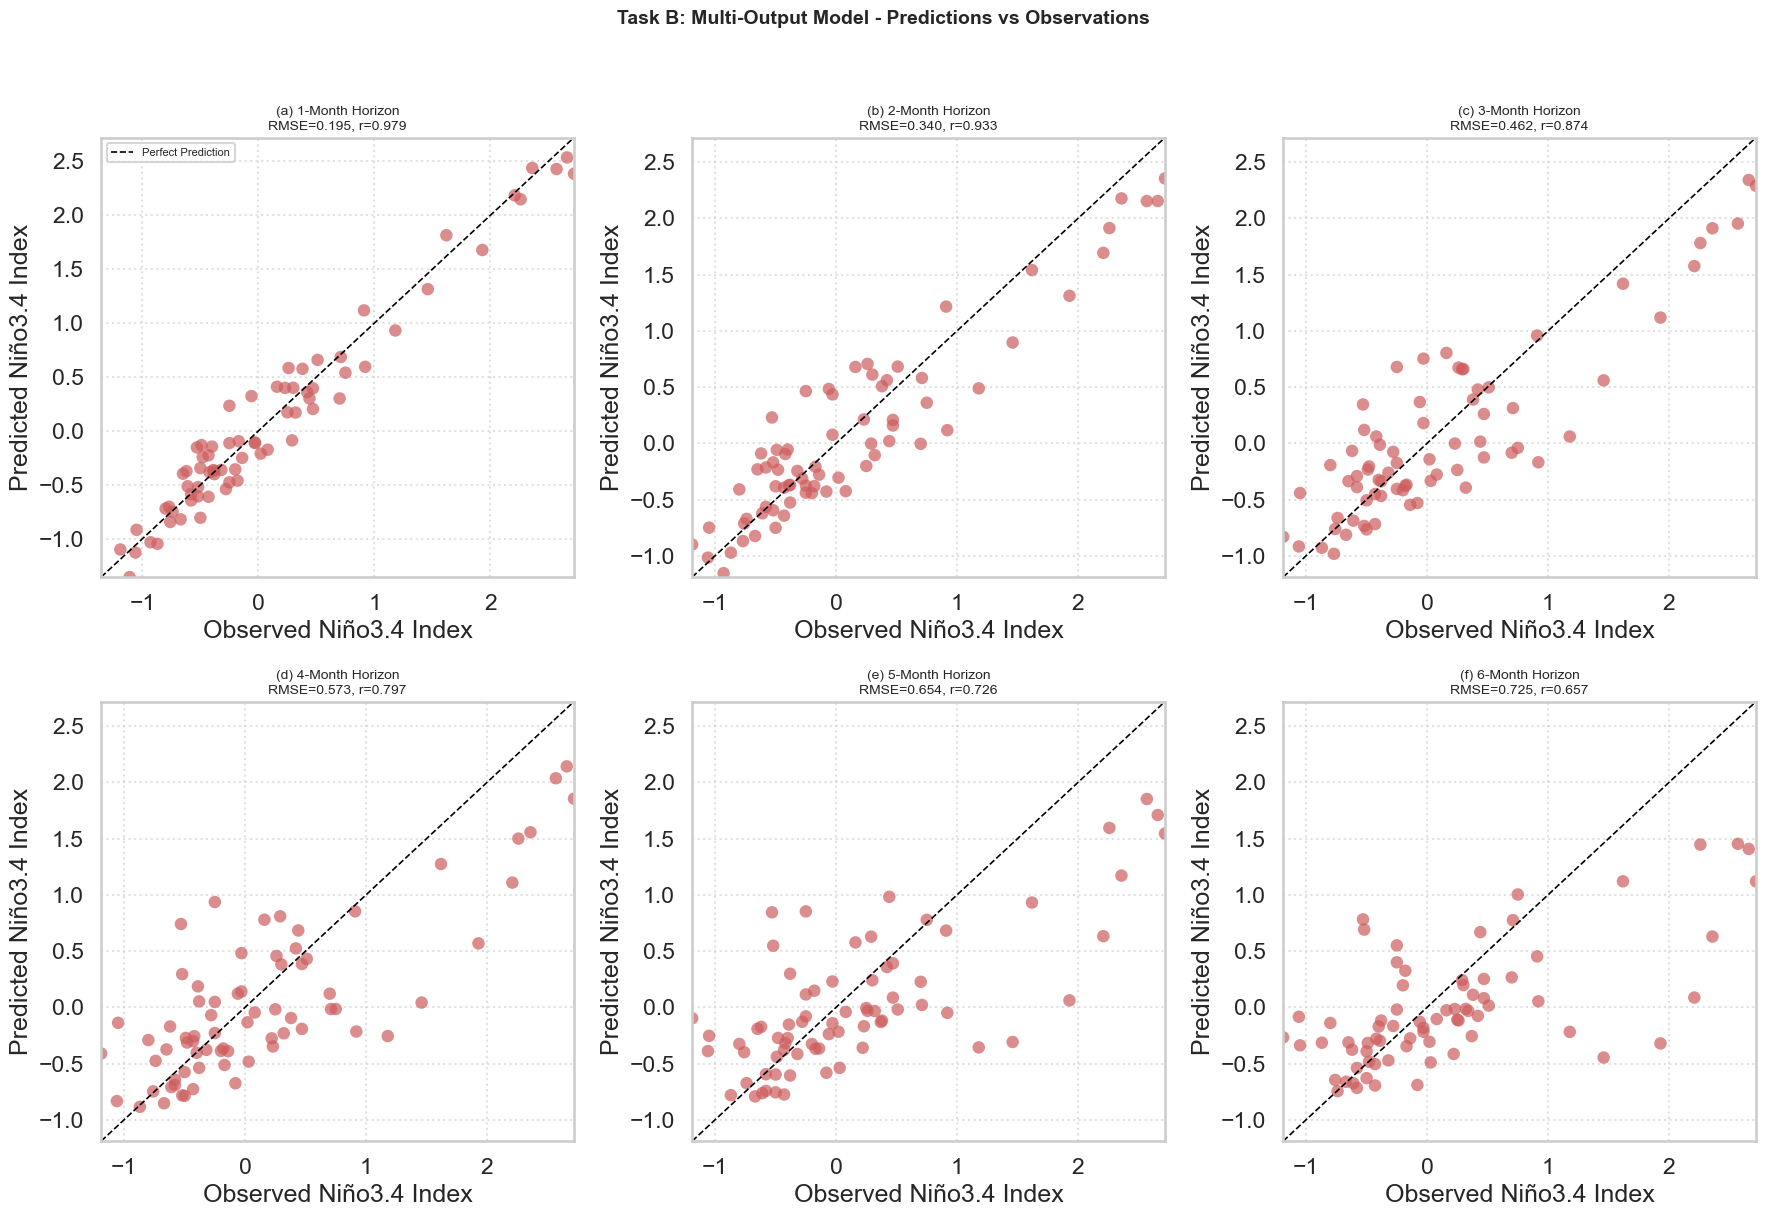

In [ ]:
# ---------- (t) Scatter Plots: Predicted vs Observed ----------

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

titles = [
    "(a) 1-Month Horizon",
    "(b) 2-Month Horizon",
    "(c) 3-Month Horizon",
    "(d) 4-Month Horizon",
    "(e) 5-Month Horizon",
    "(f) 6-Month Horizon"
]

for i, ax in enumerate(axes):
    # scatter plot
    ax.scatter(
        y_true[:, i], y_pred[:, i],
        color="indianred", alpha=0.7, edgecolor="none"
    )

    # reference line y=x
    min_val = min(y_true[:, i].min(), y_pred[:, i].min())
    max_val = max(y_true[:, i].max(), y_pred[:, i].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=1.2, label="Perfect Prediction")

    # labels and title
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)
    ax.set_title(f"{titles[i]}\nRMSE={taskB_standard_rmse[i]:.3f}, r={taskB_standard_r[i]:.3f}", fontsize=10)
    ax.set_xlabel("Observed Niño3.4 Index")
    ax.set_ylabel("Predicted Niño3.4 Index")
    ax.grid(True, linestyle=":", alpha=0.6)

    if i == 0:
        ax.legend(loc="upper left", fontsize=8)

plt.suptitle("Task B: Multi-Output Model In Hidden Dataset - Predictions vs Observations", fontsize=14, weight="bold", y=1.02)
plt.tight_layout()
plt.show()



# ---------- Scatter Plots: Predicted vs Observed ----------

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

titles = [
    "(a) 1-Month Horizon",
    "(b) 2-Month Horizon",
    "(c) 3-Month Horizon",
    "(d) 4-Month Horizon",
    "(e) 5-Month Horizon",
    "(f) 6-Month Horizon"
]

for i, ax in enumerate(axes):
    # scatter plot
    ax.scatter(
        y_true_weighted[:, i], y_pred_weighted[:, i],
        color="indianred", alpha=0.7, edgecolor="none"
    )

    # reference line y=x
    min_val = min(y_true_weighted[:, i].min(), y_pred_weighted[:, i].min())
    max_val = max(y_true_weighted[:, i].max(), y_pred_weighted[:, i].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=1.2, label="Perfect Prediction")

    # labels and title
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)
    ax.set_title(f"{titles[i]}\nRMSE={taskB_weighted_rmse[i]:.3f}, r={taskB_weighted_r[i]:.3f}", fontsize=10)
    ax.set_xlabel("Observed Niño3.4 Index")
    ax.set_ylabel("Predicted Niño3.4 Index")
    ax.grid(True, linestyle=":", alpha=0.6)

    if i == 0:
        ax.legend(loc="upper left", fontsize=8)

plt.suptitle("Task B: Multi-Output Model -Weighted - Predictions vs Observations", fontsize=14, weight="bold", y=1.02)
plt.tight_layout()
plt.show()